In [1]:
import os

os.chdir('..')

import tqdm

import numpy as np
import tensorflow as tf

# Get rid of the deprecation warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import matplotlib.pyplot as plt
import matplotlib as mpl

#from tensorflow.python.lib.io import tf_record
#from tensorflow.core.util import event_pb2
#from tensorflow.python.framework import tensor_util

from models.models import DeepStatisticalSolver

/Users/balthazardonon/Documents/PhD/Code.nosync/2020/ICLR_DeepStatisticalSolver/ENV/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/balthazardonon/Documents/PhD/Code.nosync/2020/ICLR_DeepStatisticalSolver/ENV/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/balthazardonon/Documents/PhD/Code.nosync/2020/ICLR_DeepStatisticalSolver/ENV/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it

This notebook considers the linear systems derived from the Poisson equation.


The current notebook is composed of the following parts:
- Reload a trained model
- Compute the important metrics (same as the ones displayed in the paper)
- Visualize the evolution of the loss, latent variables and actual prediction
- Generalize to datasets of varying size (change the amount of nodes)

# Reloading a model

In [2]:
# Enter path to model. Three pre-trained models are available : best_linear_0, best_linear_1, best_linear_2
model_path = "results/proxy_linear_0"

# Enter path to data to build architecture
data_dir = 'datasets/linear_systems'

# Initialize a tensorflow session
sess = tf.Session()

# Build the Deep Statistical Solver
model = DeepStatisticalSolver(sess, 
                          model_to_restore=model_path, 
                          default_data_directory=data_dir)

In [3]:
# Load the test set (change the mode variable if you want val or train)
mode = 'test'

# Import numpy data
A_np = np.load(os.path.join(data_dir, 'A_'+mode+'.npy'))
B_np = np.load(os.path.join(data_dir, 'B_'+mode+'.npy'))
U_np = np.load(os.path.join(data_dir, 'U_'+mode+'.npy'))
coord_np = np.load(os.path.join(data_dir, 'coord_'+mode+'.npy'))

# Computing metrics

In [4]:
# For the whole dataset, we will compute both the individual loss of each sample, 
# and the final predictions
individual_losses_DSS_ = None
individual_losses_LU_ = None
U_DSS_ = None
U_LU_ = None

# In order to split the dataset, define the size of the batches that will be fed to the model.
# For very large dataset, it can be useful to have a small value for BATCH_SIZE
BATCH_SIZE = 100

# Get total amount of samples and split the dataset
n_samples_tot = A_np.shape[0]
n_batches = n_samples_tot // BATCH_SIZE
batched_indices = np.array_split(np.arange(n_samples_tot), n_batches) 

# Iterate over the batches
for indices in tqdm.tqdm(batched_indices):
    
    # Compute individual losses and final predictions for the DSS
    feed_dict = {model.A:A_np[indices], model.B:B_np[indices]}
    U_DSS, individual_losses_DSS = sess.run([model.U_final, 
                                         model.cost_per_sample[str(model.correction_updates)]], 
                                         feed_dict = feed_dict
                                        )
    
    feed_dict = {model.A:A_np[indices], model.B:B_np[indices], model.U_final:U_np[indices]}
    individual_losses_LU = sess.run(model.cost_per_sample[str(model.correction_updates)], 
                                         feed_dict = feed_dict
                                        )
        
    # Getting prediction
    U_DSS = np.reshape(U_DSS[:, :, 0], -1)

    # Getting LU solution
    U_LU = np.reshape(U_np[indices, :, 0], -1)

    if individual_losses_DSS_ is None:
        individual_losses_DSS_ = individual_losses_DSS
        individual_losses_LU_ = individual_losses_LU
        U_DSS_ = U_DSS
        U_LU_ = U_LU
        
    else:
        individual_losses_DSS_ = np.concatenate([individual_losses_DSS_, individual_losses_DSS])
        individual_losses_LU_ = np.concatenate([individual_losses_LU_, individual_losses_LU])
        U_DSS_ = np.concatenate([U_DSS_, U_DSS])
        U_LU_ = np.concatenate([U_LU_, U_LU])



100%|██████████| 320/320 [14:48<00:00,  2.78s/it]


In [5]:
print(U_DSS_.shape)


(19203940,)


In [6]:
print('Losses - DSS')
print('    10th percentile = {}'.format(np.percentile(individual_losses_DSS_, 10)))
print('    50th percentile = {}'.format(np.percentile(individual_losses_DSS_, 50)))
print('    90th percentile = {}'.format(np.percentile(individual_losses_DSS_, 90)))
print('Losses - LU')
print('(Keep in mind that the maximum precision achieved by tf.float32 is around 1e-14')
print('Thus the loss computed by tensorflow is very noisy w.r.t. LU method)')
print('    10th percentile = {}'.format(np.percentile(individual_losses_LU_, 10)))
print('    50th percentile = {}'.format(np.percentile(individual_losses_LU_, 50)))
print('    90th percentile = {}'.format(np.percentile(individual_losses_LU_, 90)))
print('Comparison between methods DSS and LU')
print('    Correlation = {}'.format(np.corrcoef(U_LU_,U_DSS_)[1,0]))
print('    RMSE = {}'.format(np.sqrt(np.mean((U_DSS_-U_LU_)**2))))
print('    normalized RMSE = {}'.format(np.sqrt(np.mean((U_DSS_-U_LU_)**2))\
      /(np.max(U_LU_)-np.min(U_LU_))))
print('    MAE = {}'.format(np.mean(np.abs(U_DSS_-U_LU_))))
print('    normalized MAE = {}'.format(np.mean(np.abs(U_DSS_-U_LU_))\
      /(np.max(U_LU_)-np.min(U_LU_))))

Losses - DSS
    10th percentile = 0.006988271605223417
    50th percentile = 0.015571566298604012
    90th percentile = 0.03995716124773025
Losses - LU
(Keep in mind that the maximum precision achieved by tf.float32 is around 1e-14
Thus the loss computed by tensorflow is very noisy w.r.t. LU method)
    10th percentile = 2.388076037916284e-13
    50th percentile = 3.2004968337009942e-12
    90th percentile = 1.6080444788235672e-11
Comparison between methods DSS and LU
    Correlation = 0.9999668088852939
    RMSE = 0.28396440913633264
    normalized RMSE = 0.0010916738806464549
    MAE = 0.17301390828402324
    normalized MAE = 0.0006651353429702164


We observe a correlation of 99.99% between our prediction and the LU method!

# Visualize loss, H and U

In [7]:
# Let's pick a random sample
sample = np.random.randint(0,A_np.shape[0])

# Predict and gather latent variables, intermediate predictions and the loss
feed_dict = {model.A:A_np[sample:sample+1], model.B:B_np[sample:sample+1]}
H_list, U_list, loss_list = sess.run([model.H, model.U, model.loss], feed_dict = feed_dict)

In [8]:
# Convert those dictionaries into actual np array
U = np.array([u[0,:,0] for u in U_list.values()])
H = np.array([h[0,:,:] for h in H_list.values()])
loss = np.array([l for l in loss_list.values()])

## Loss visualization

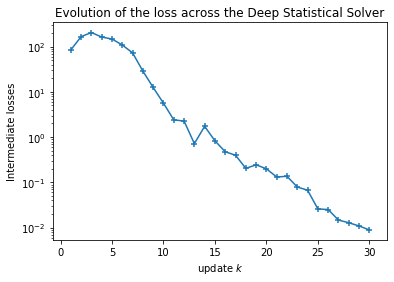

In [9]:
# Plotting the loss
plt.plot(np.arange(1,loss.shape[0]+1),loss)
plt.scatter(np.arange(1,loss.shape[0]+1), loss, marker='+')
plt.yscale('log')
plt.ylabel('Intermediate losses')
plt.xlabel(r'update $k$')
plt.title('Evolution of the loss across the Deep Statistical Solver')
plt.show()

The loss decreases by 5 orders of magnitude between the first prediction and the final

## Structure of the graph

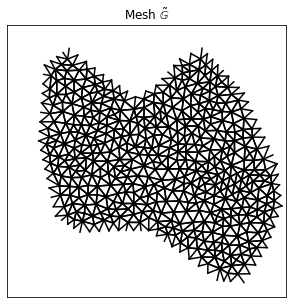

In [10]:
edges_or = A_np[sample, :, 0].astype(np.int32)
edges_ex = A_np[sample, :, 1].astype(np.int32)

# Creating mesh coordinates
coordinates = coord_np[sample]
coordinates_or_x = coordinates[edges_or, 0]
coordinates_or_y = coordinates[edges_or, 1]
coordinates_ex_x = coordinates[edges_ex, 0]
coordinates_ex_y = coordinates[edges_ex, 1]

coordinates_edge_x = np.c_[coordinates_or_x, coordinates_ex_x]
coordinates_edge_y = np.c_[coordinates_or_y, coordinates_ex_y]

plt.figure(figsize=[5,5])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelleft=False) # labels along the bottom edge are off

plt.plot(coordinates_edge_x.T, coordinates_edge_y.T, 'k', zorder=1)
plt.xlim([1,2])
plt.ylim([1,2])
plt.title(r'Mesh $\tilde{\mathbb{G}}$')
plt.show()


This is the undirected and unweighted graph that bears the structure of the problem instance.


## Intermediate predictions

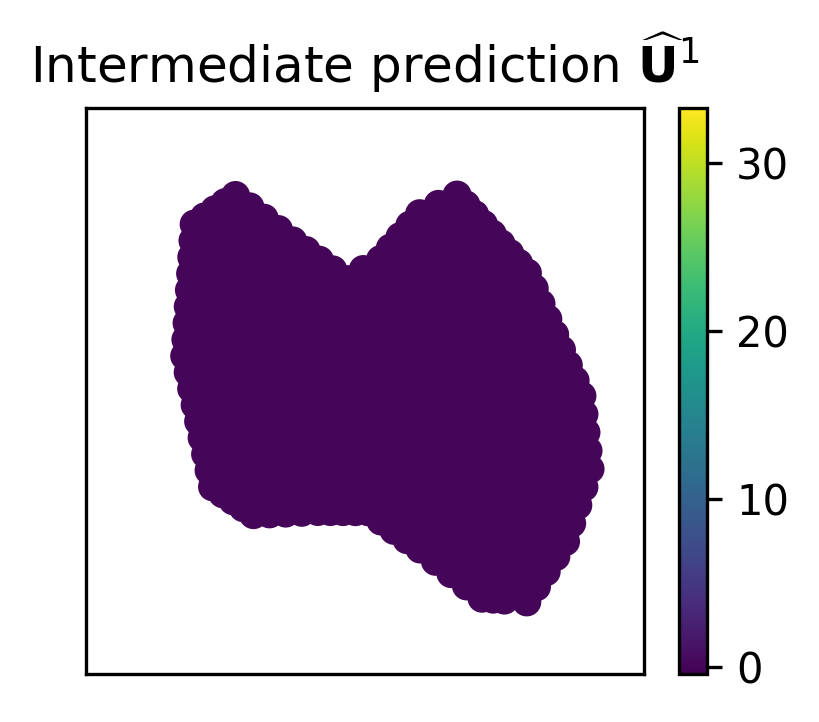

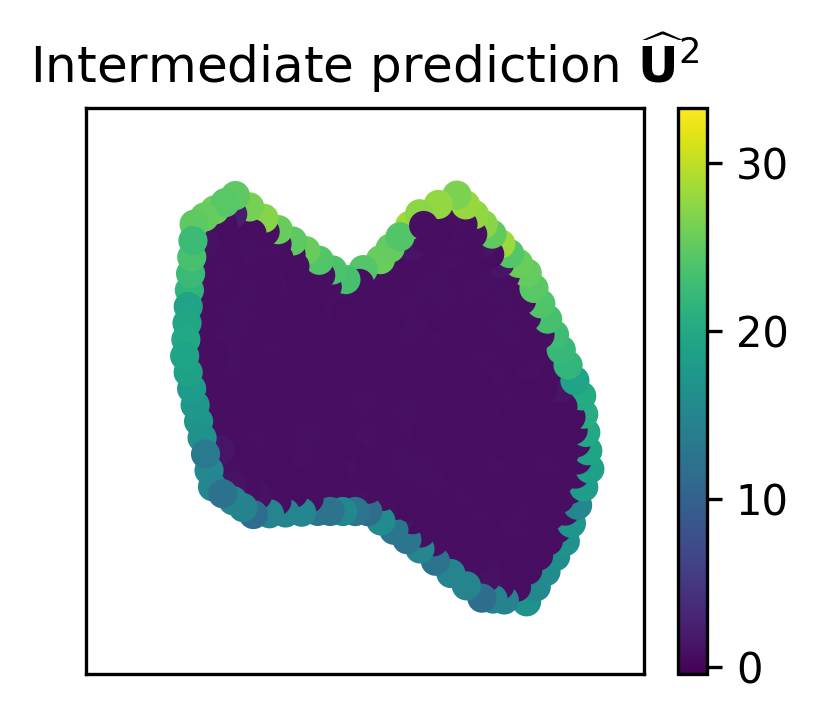

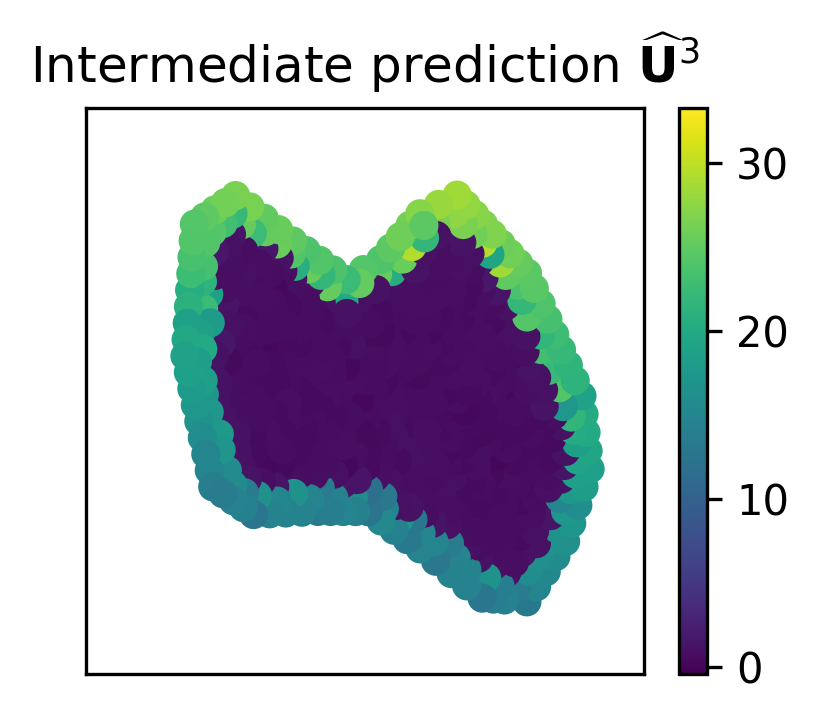

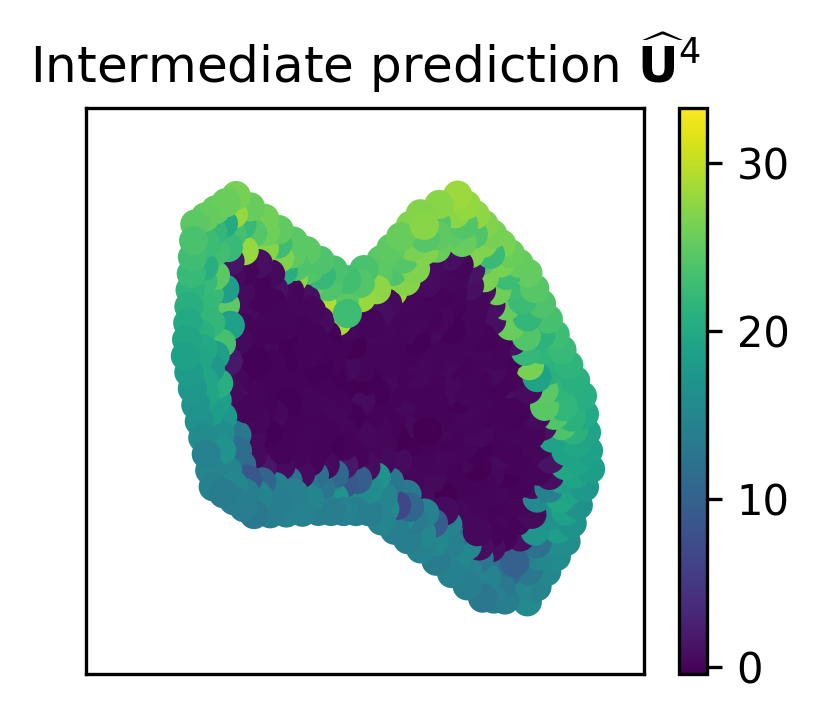

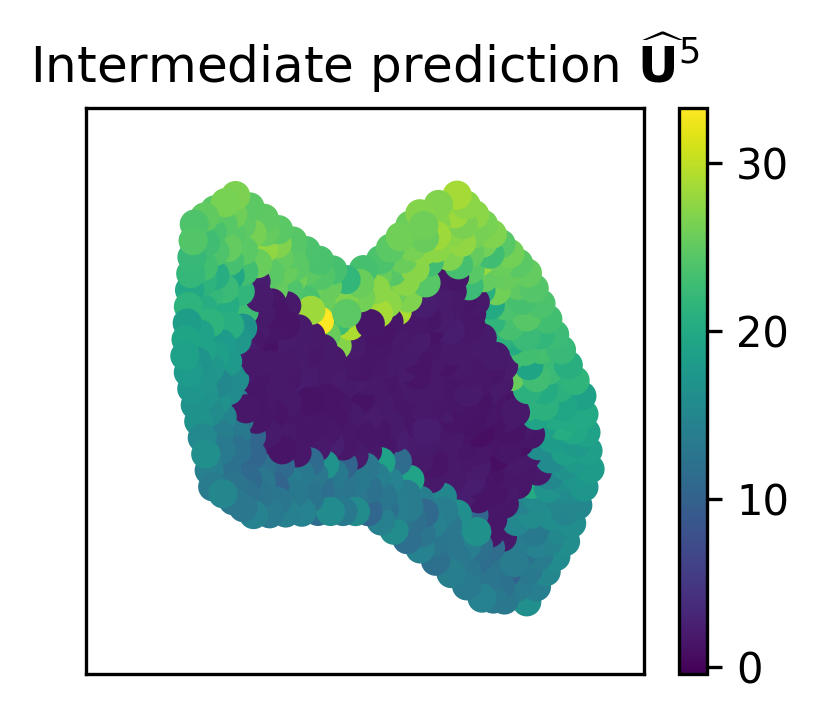

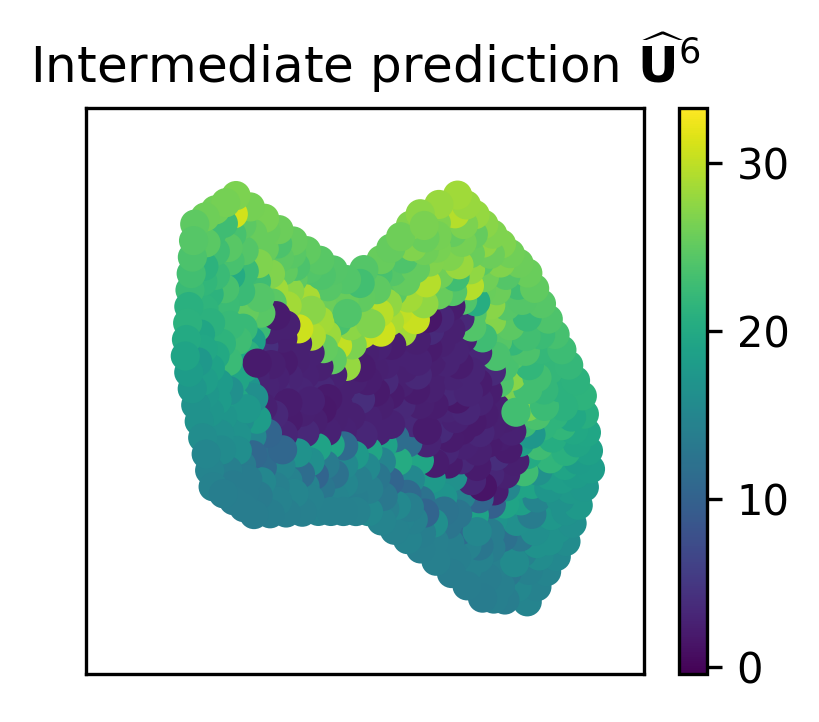

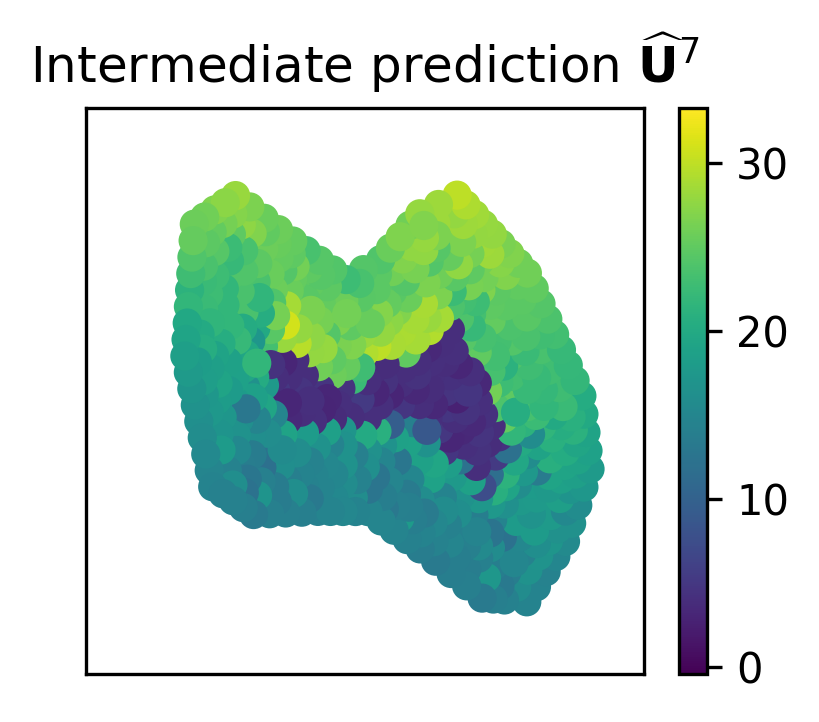

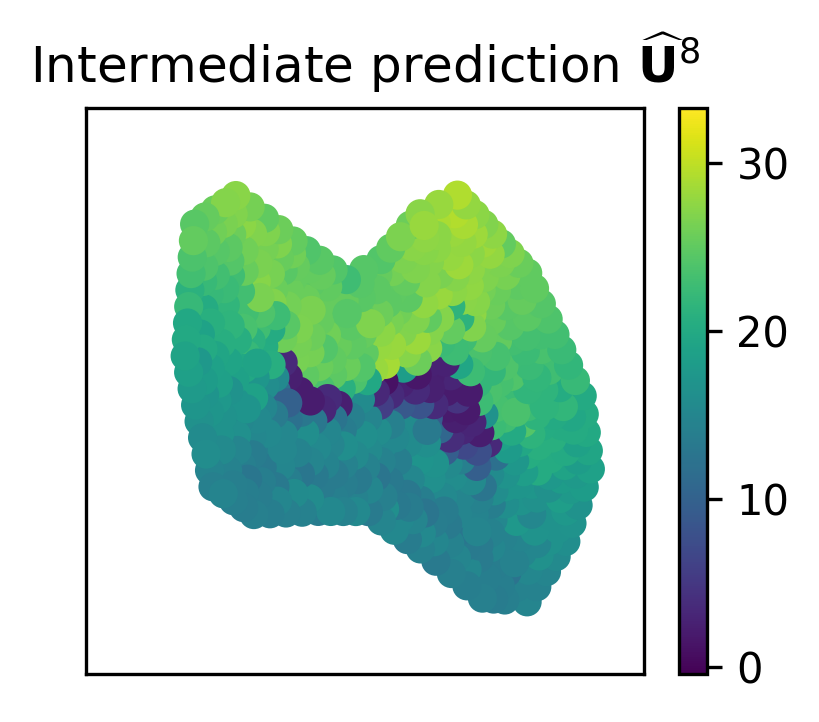

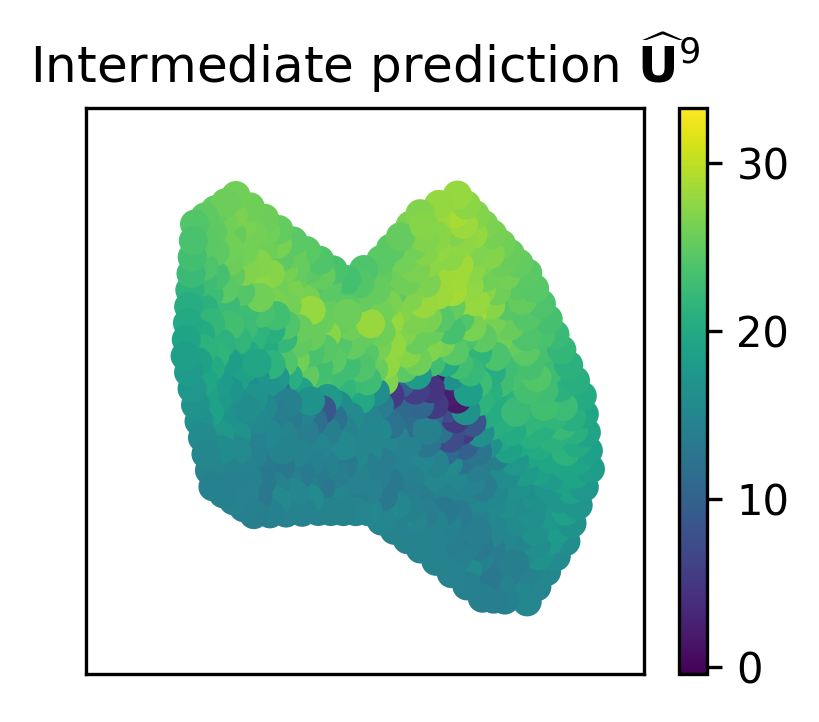

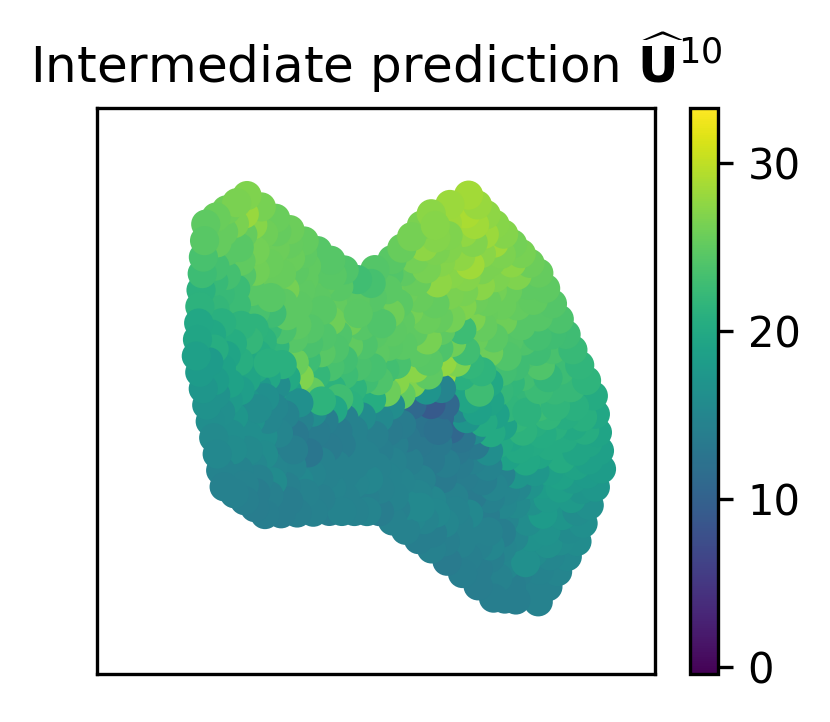

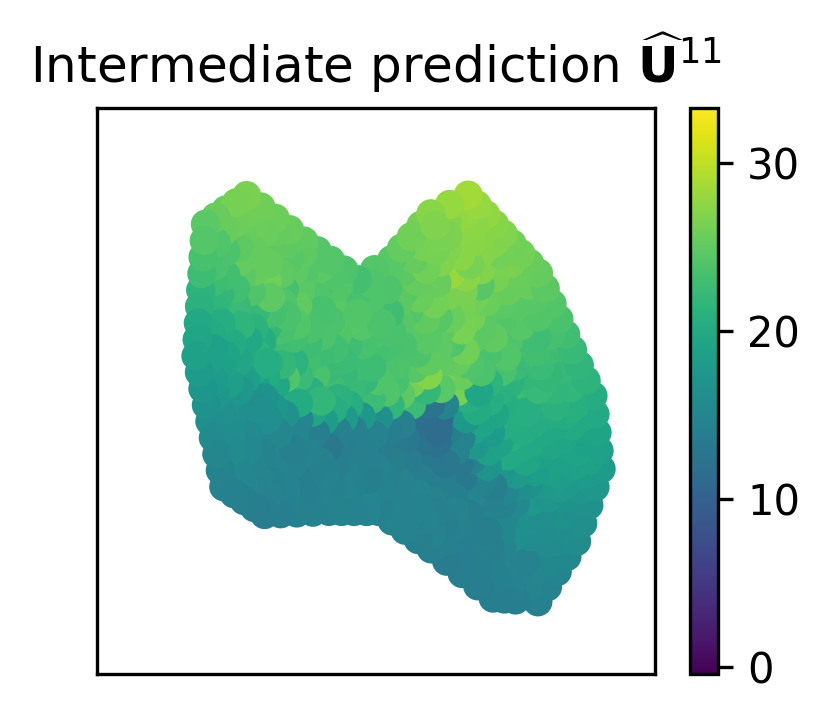

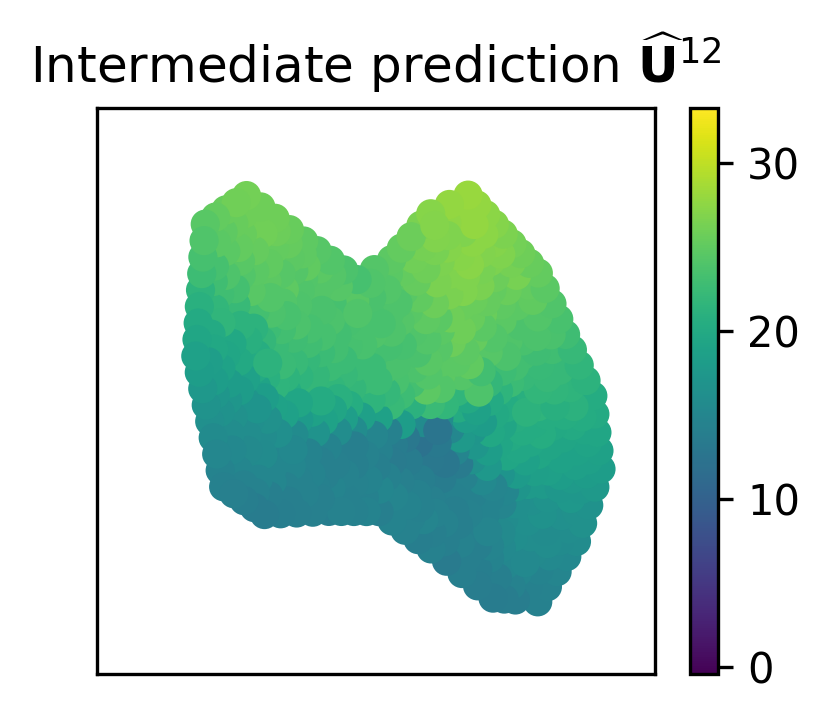

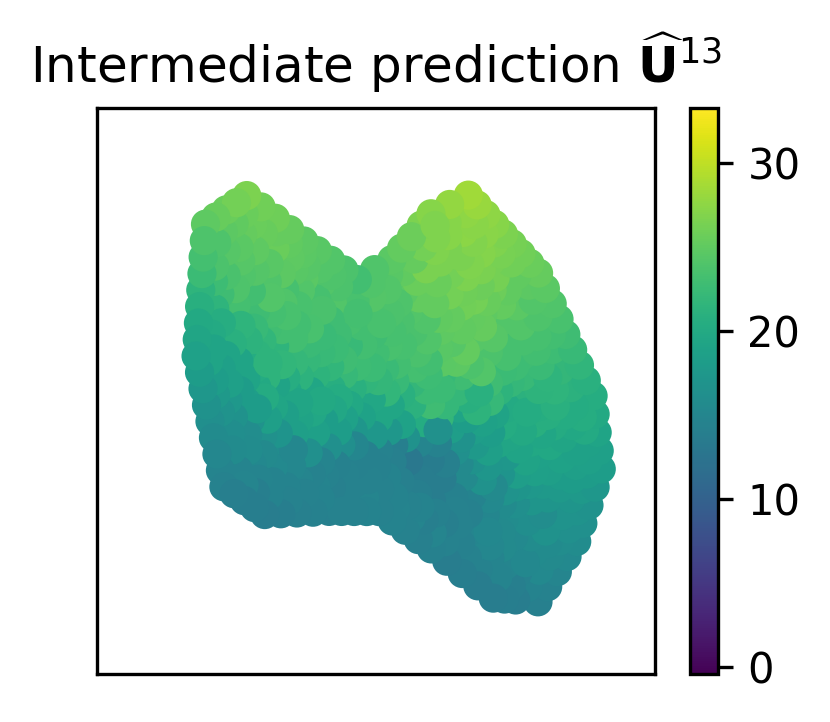

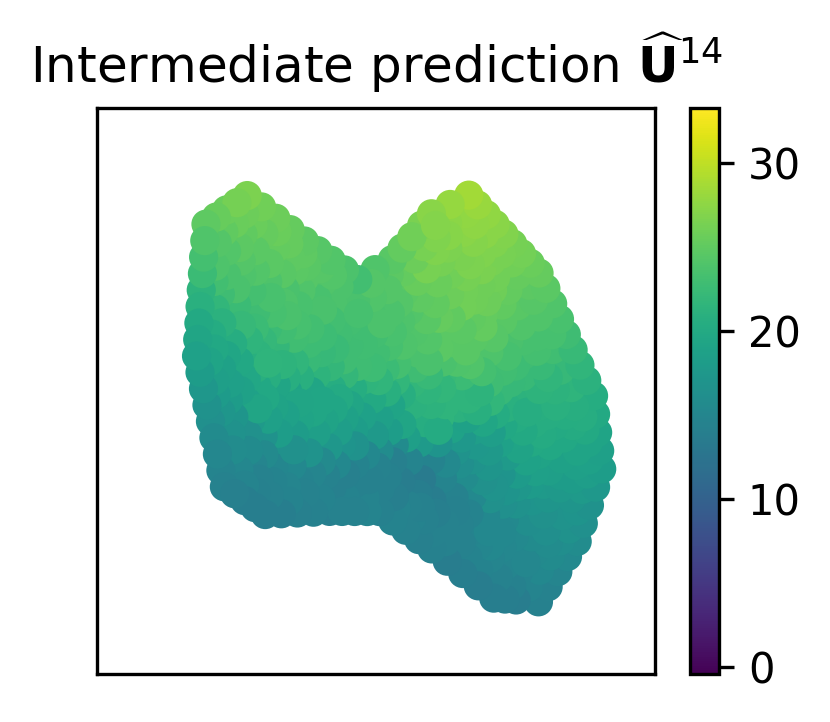

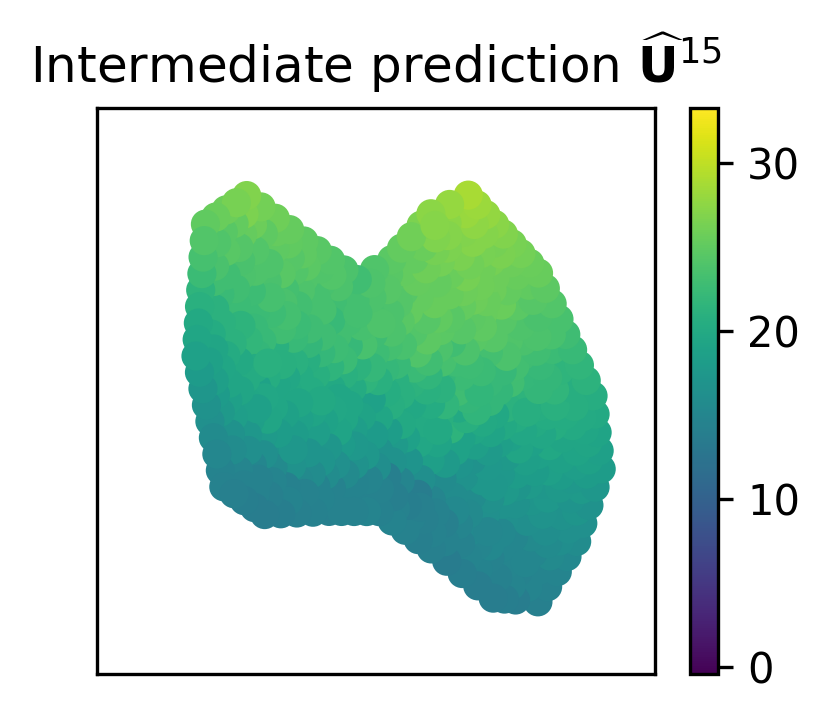

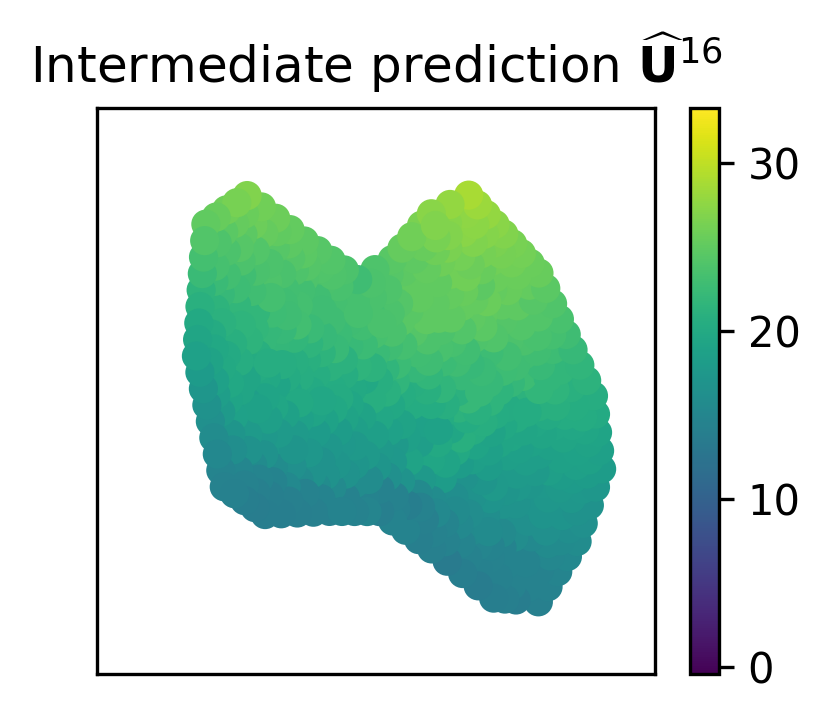

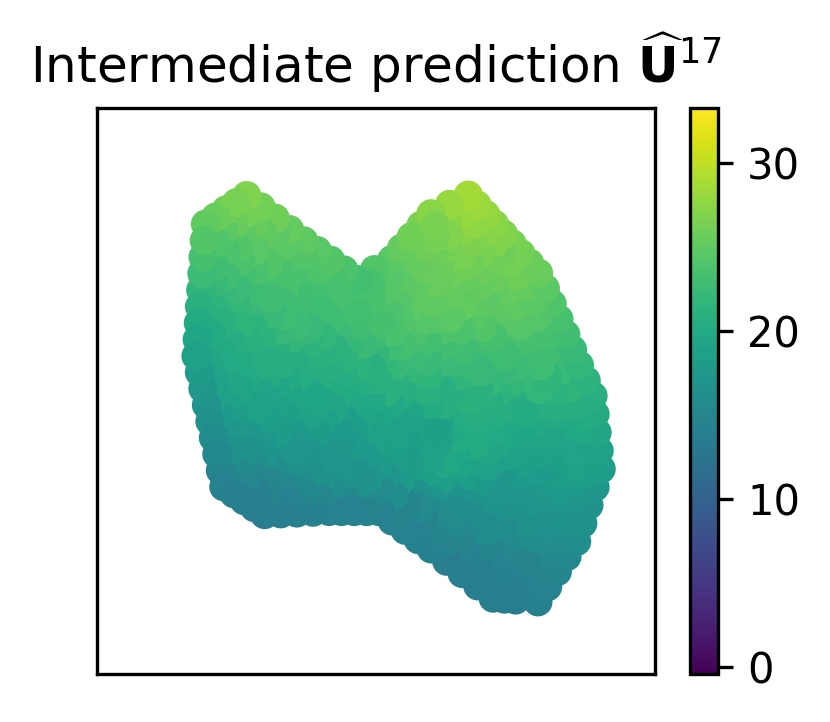

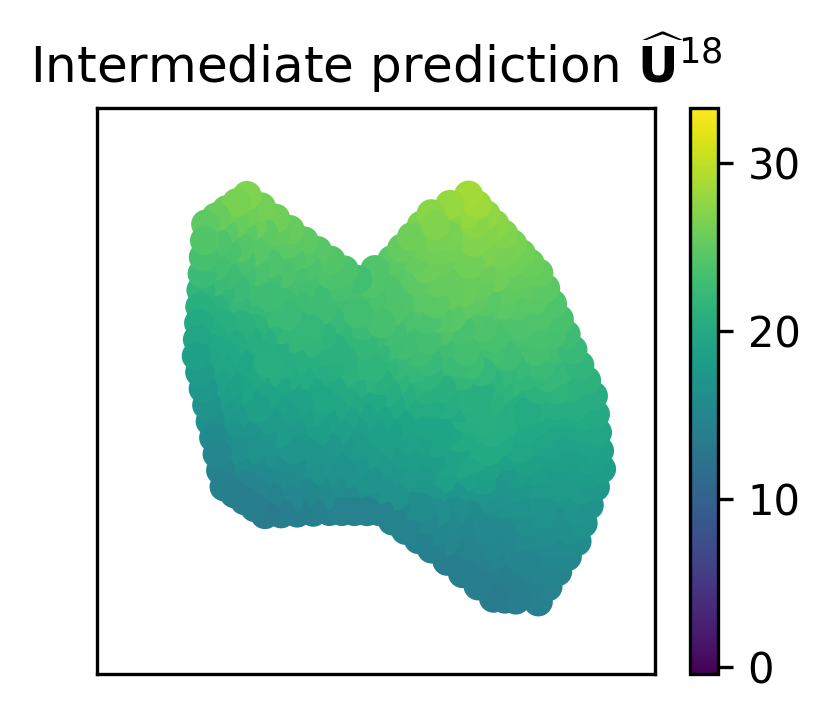

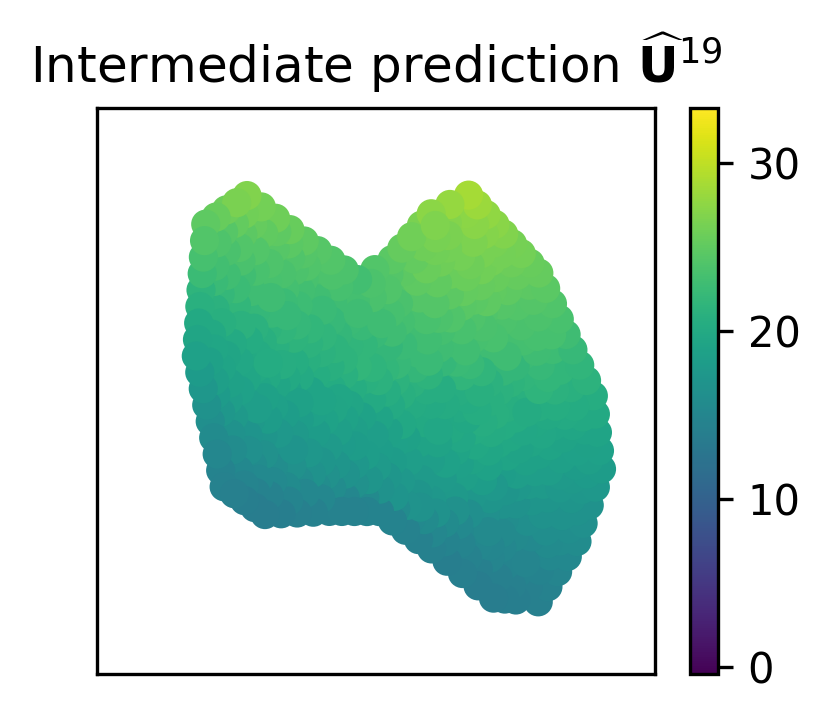

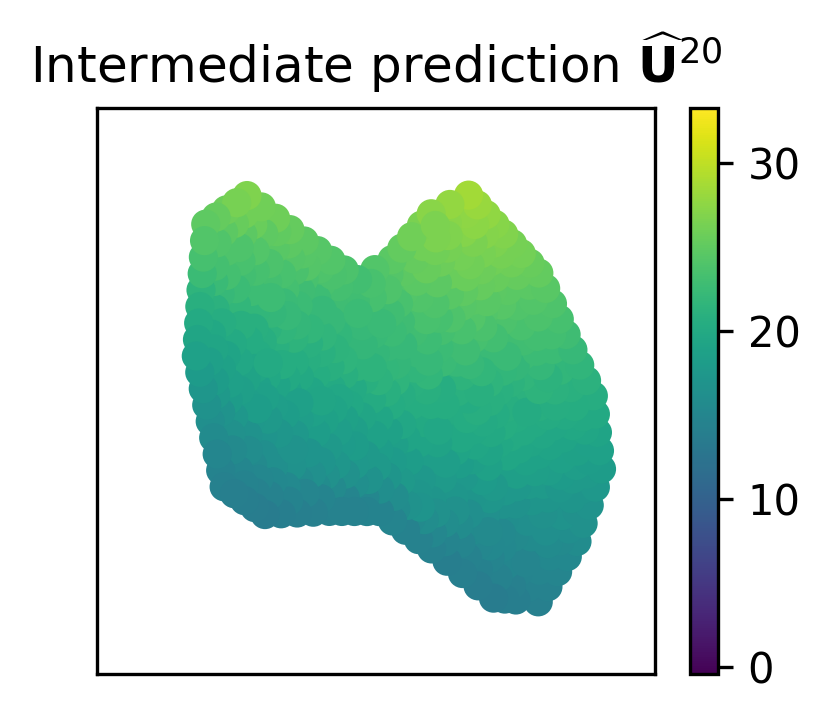

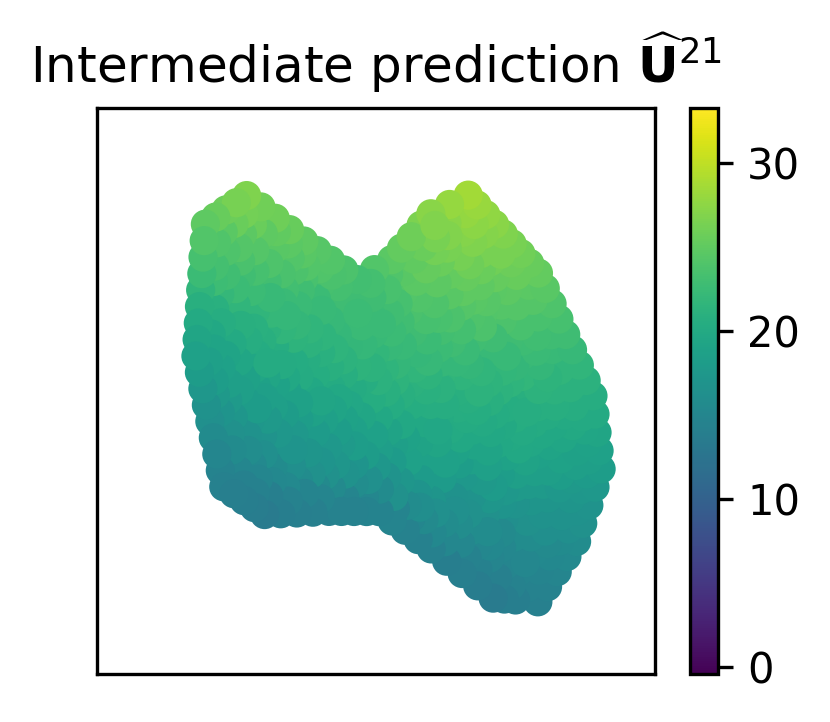

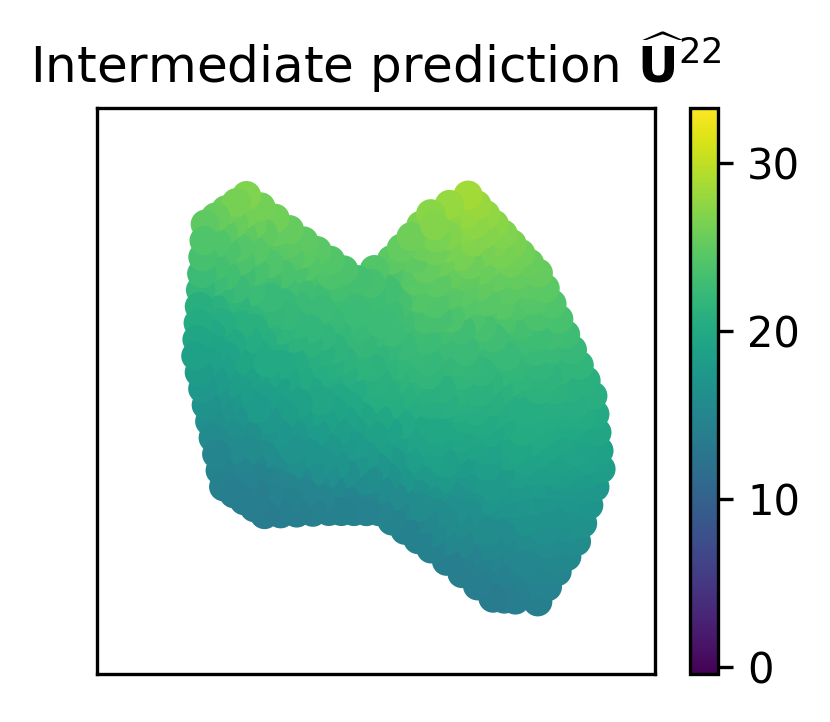

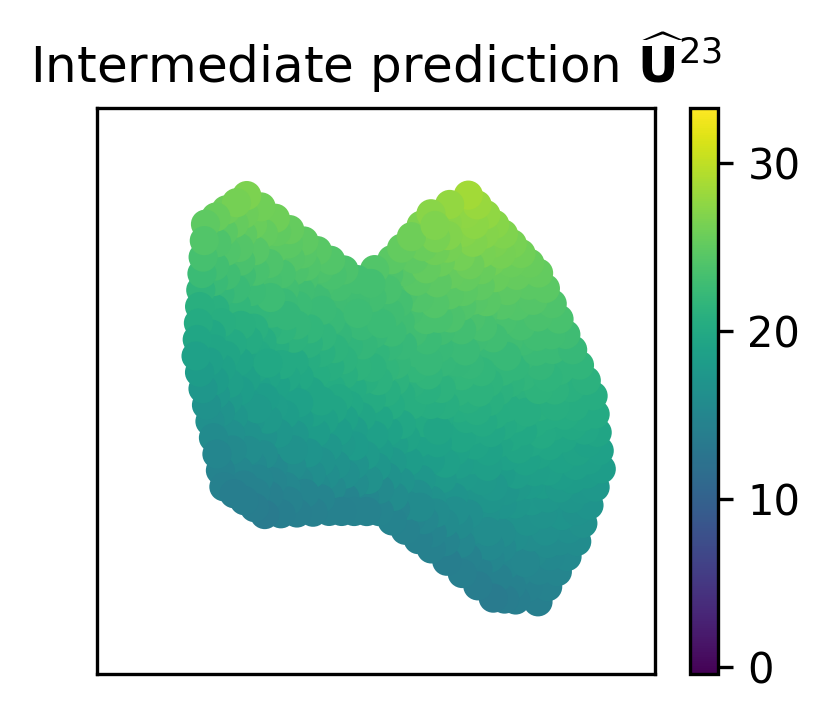

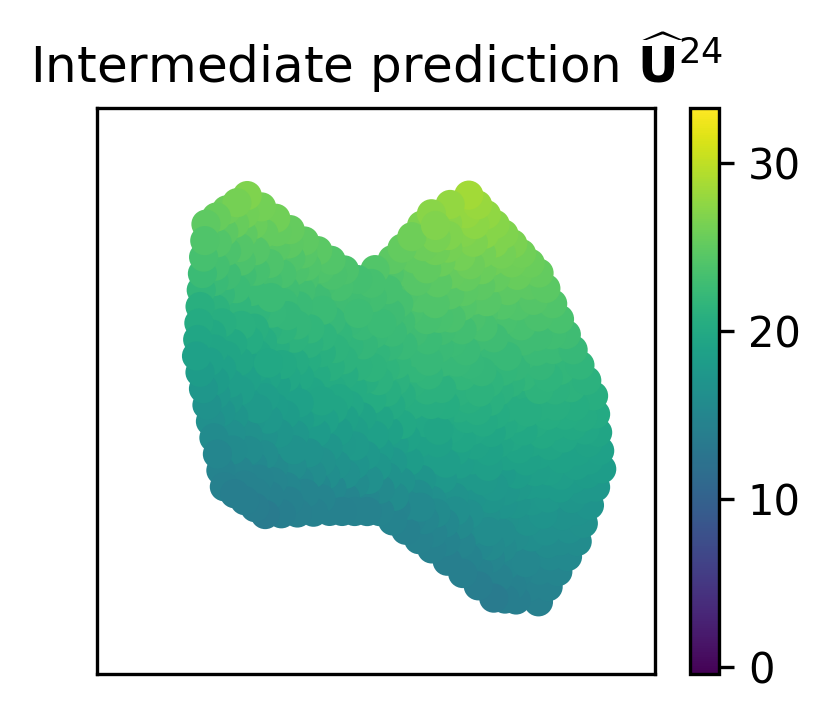

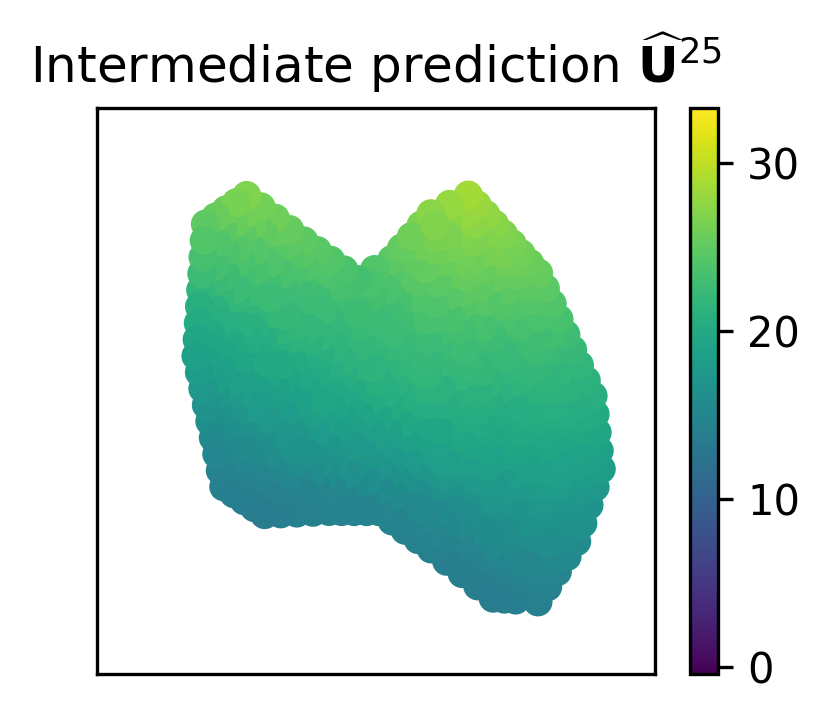

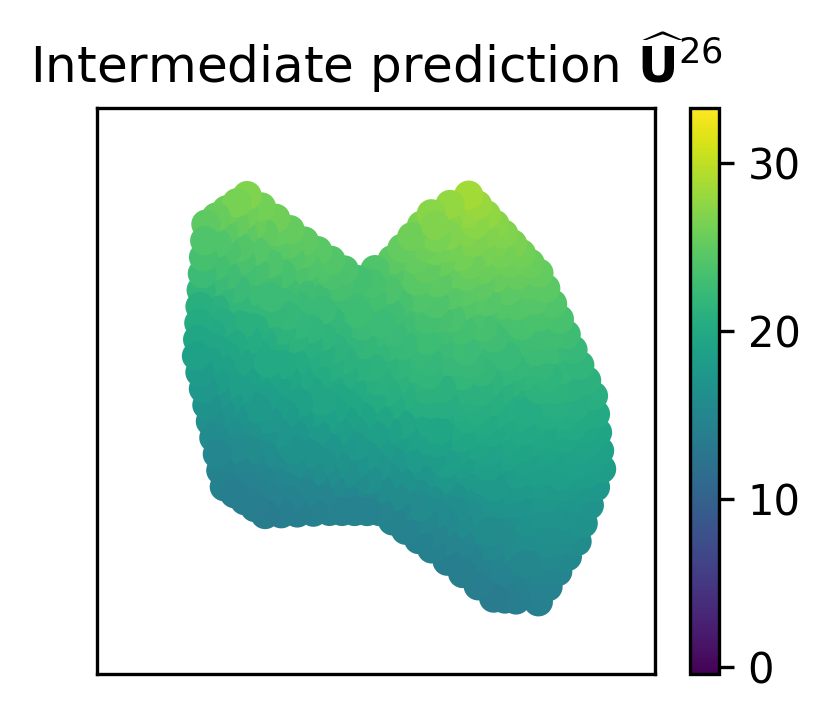

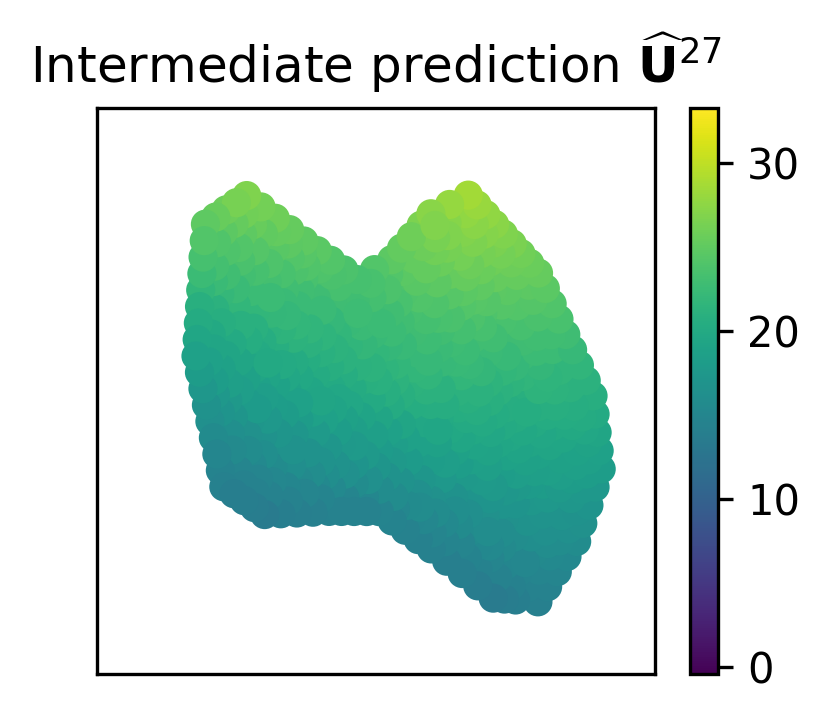

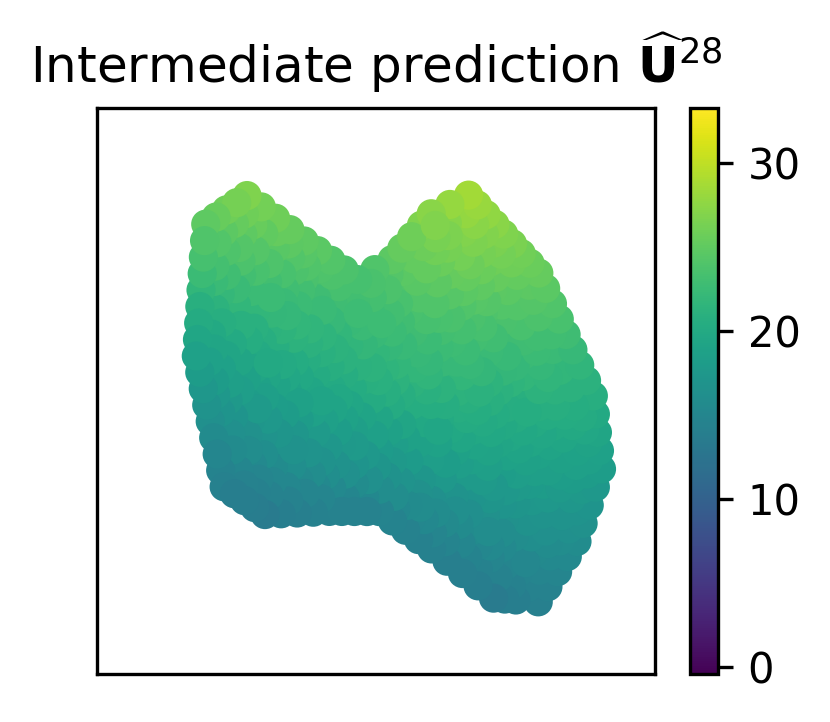

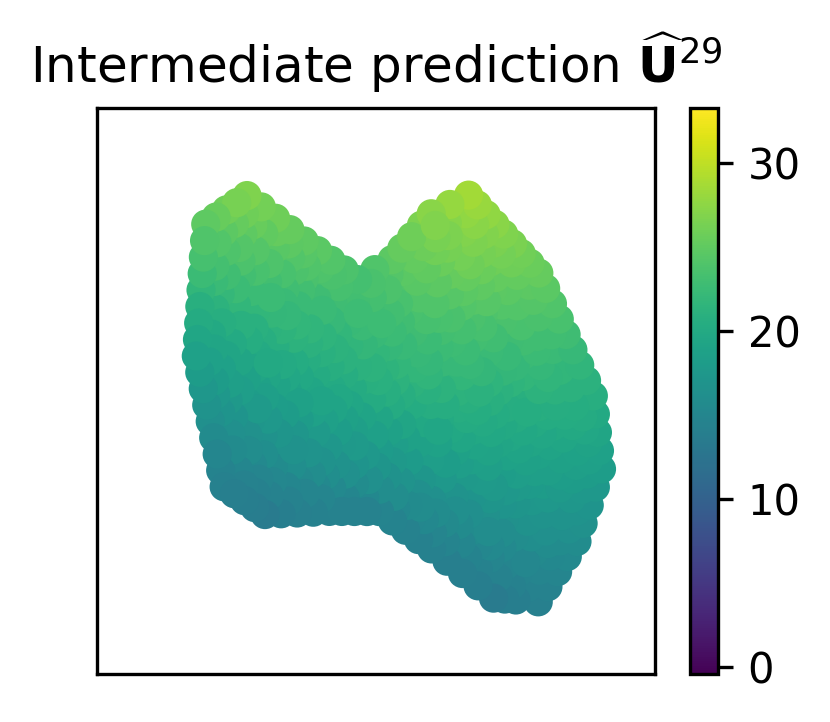

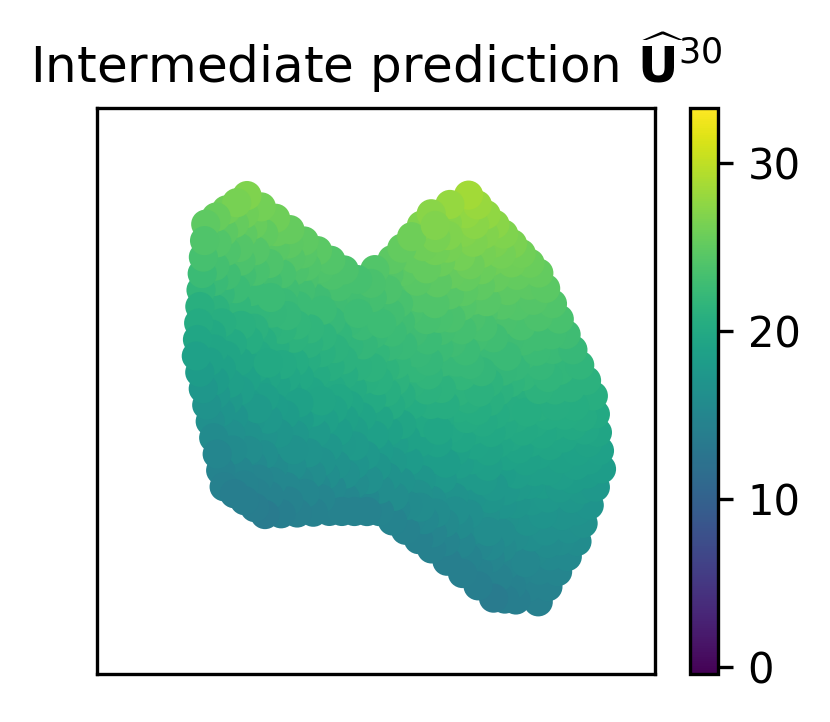

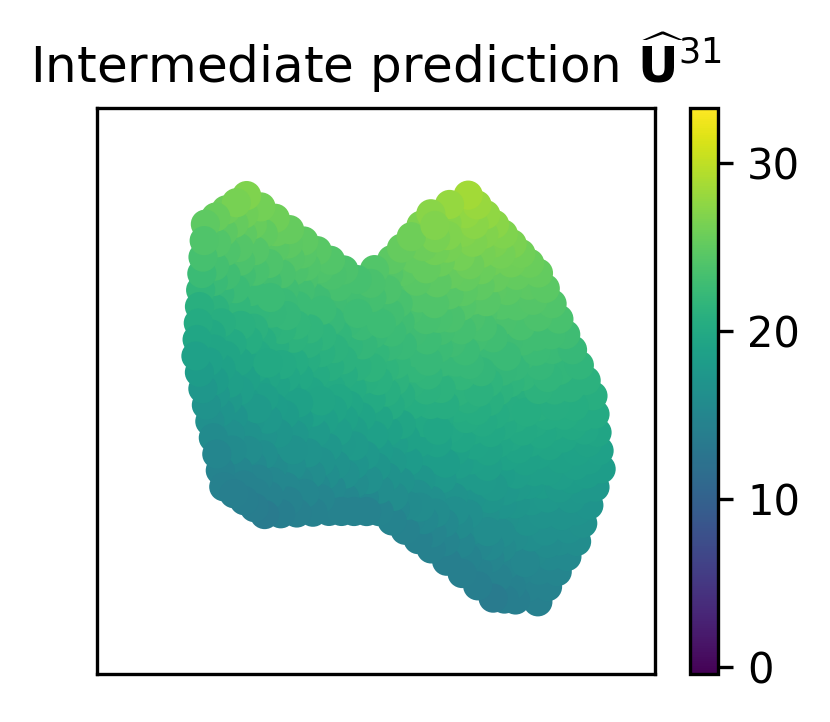

In [11]:
max_x = np.max(U)
min_x = np.min(U)

for frame in range(U.shape[0]):
    plt.figure(figsize=[3,2.5], dpi=300)
    
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelleft=False) # labels along the bottom edge are off
    
    plt.scatter(coordinates[:,0], coordinates[:,1], c=U[frame,:], zorder=2)
    plt.clim(min_x, max_x)
    plt.xlim([0.9,2.1])
    plt.ylim([0.9,2.1])
    plt.colorbar()
    plt.title(r'Intermediate prediction $\widehat{\mathbf{U}}^{'+str(frame+1)+'}$')
    plt.show()

One can see that the information propagates from the boundaries to the inside of the shape

## Latent variables evolution

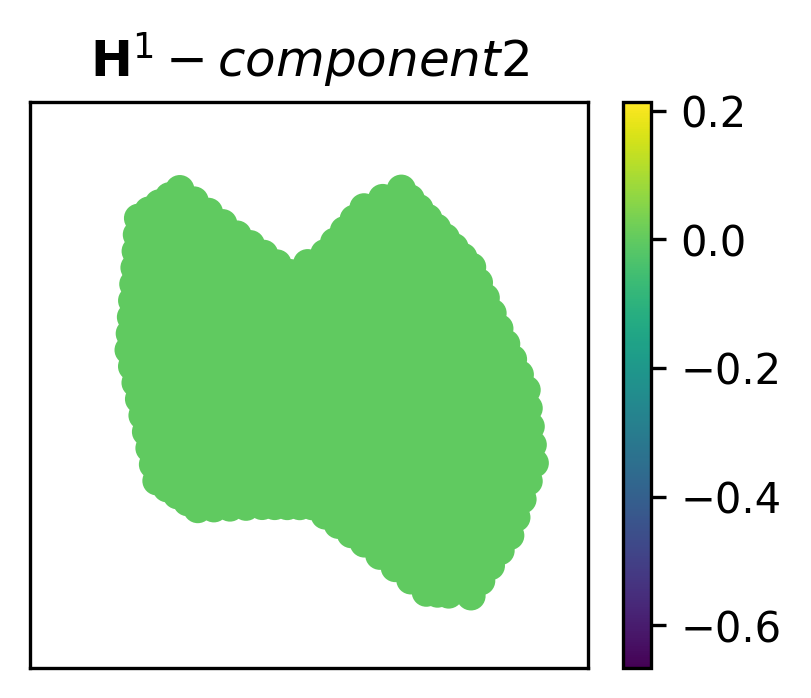

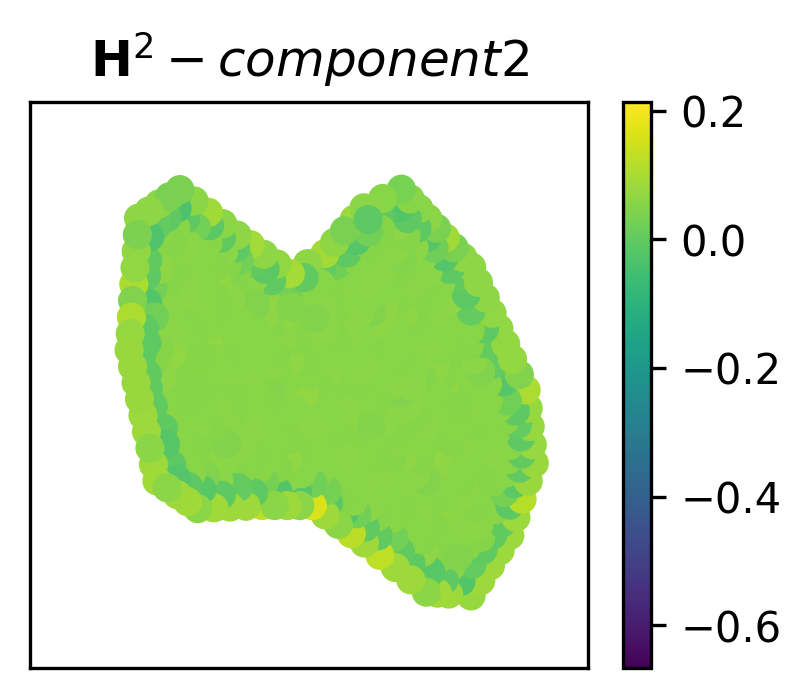

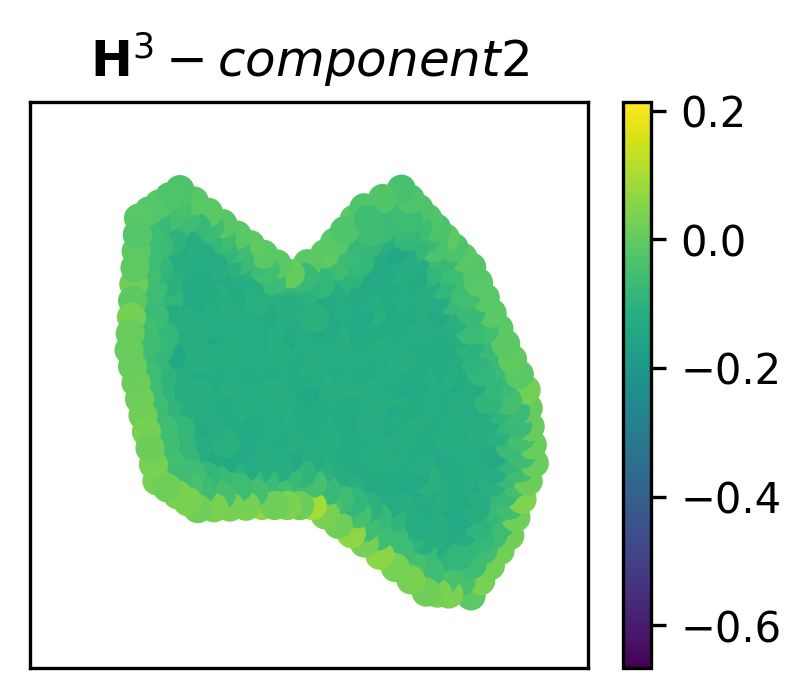

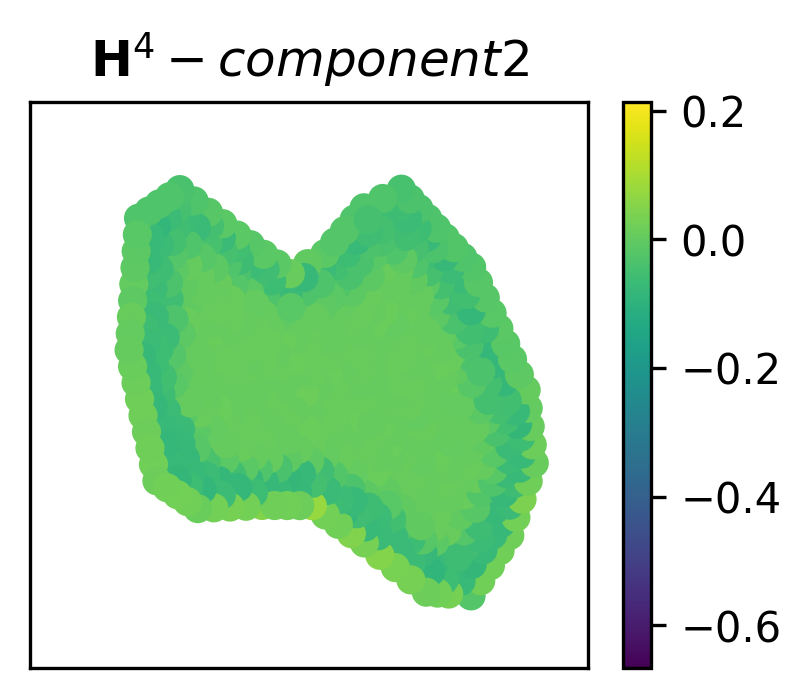

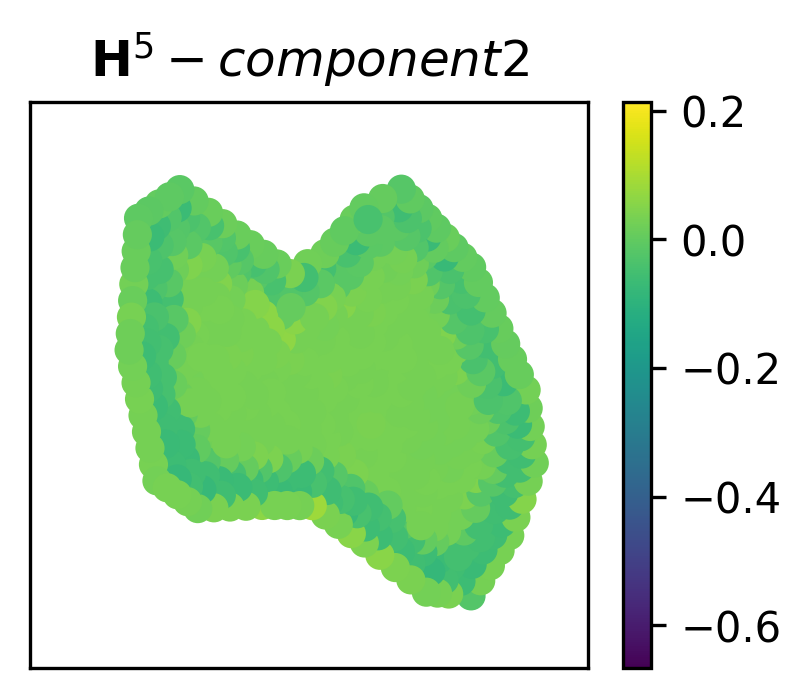

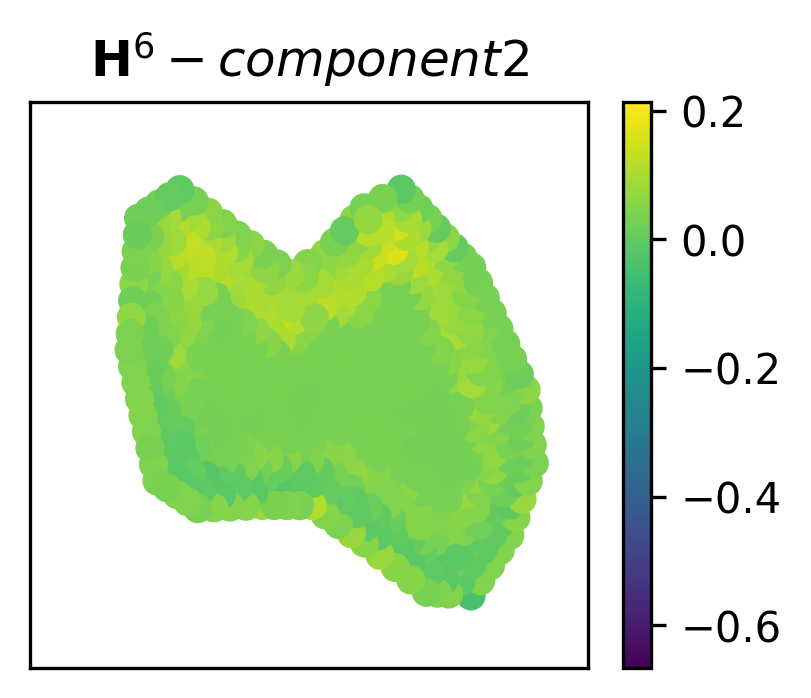

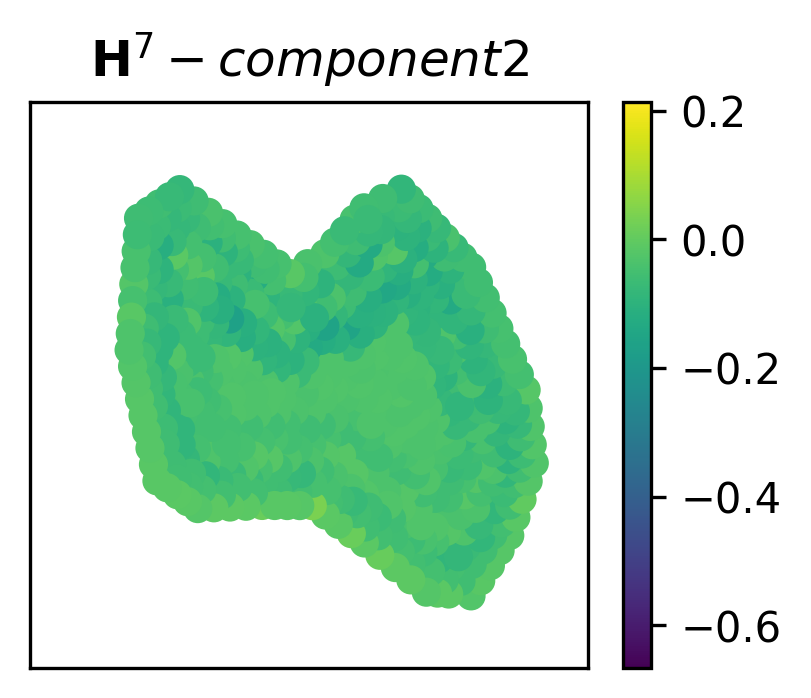

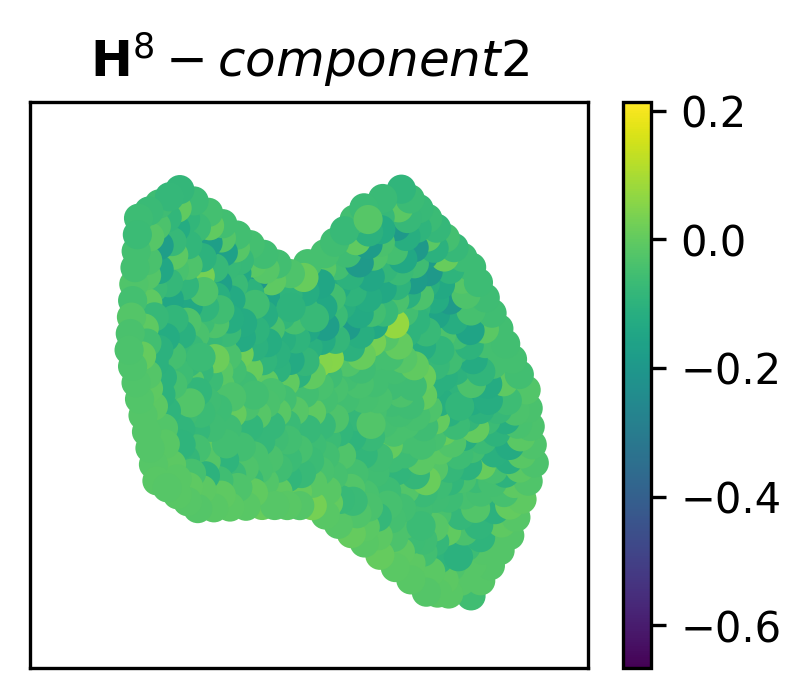

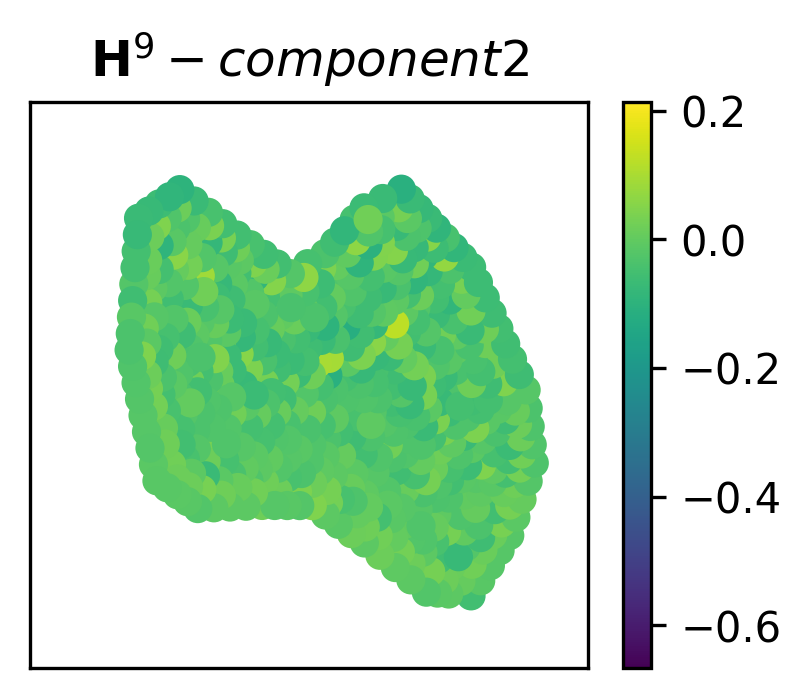

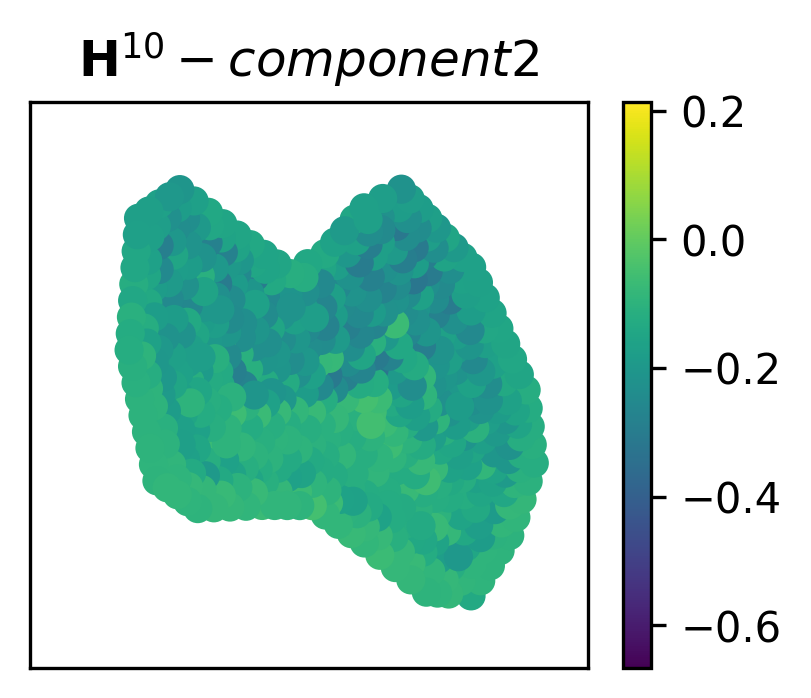

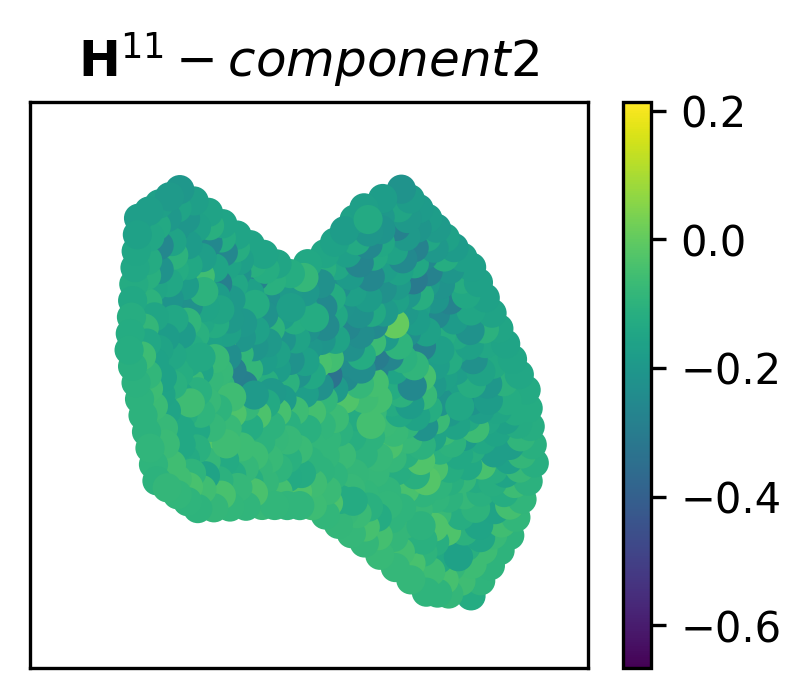

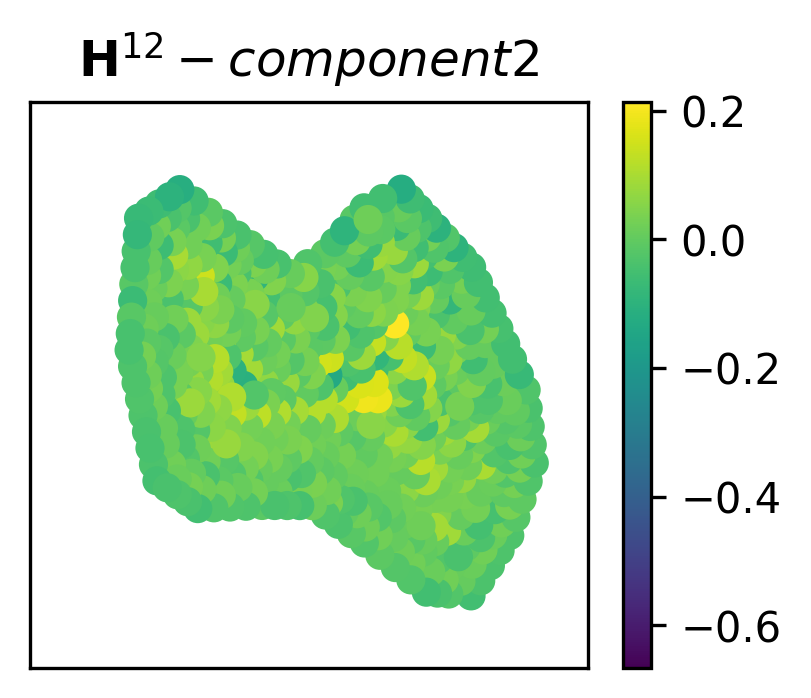

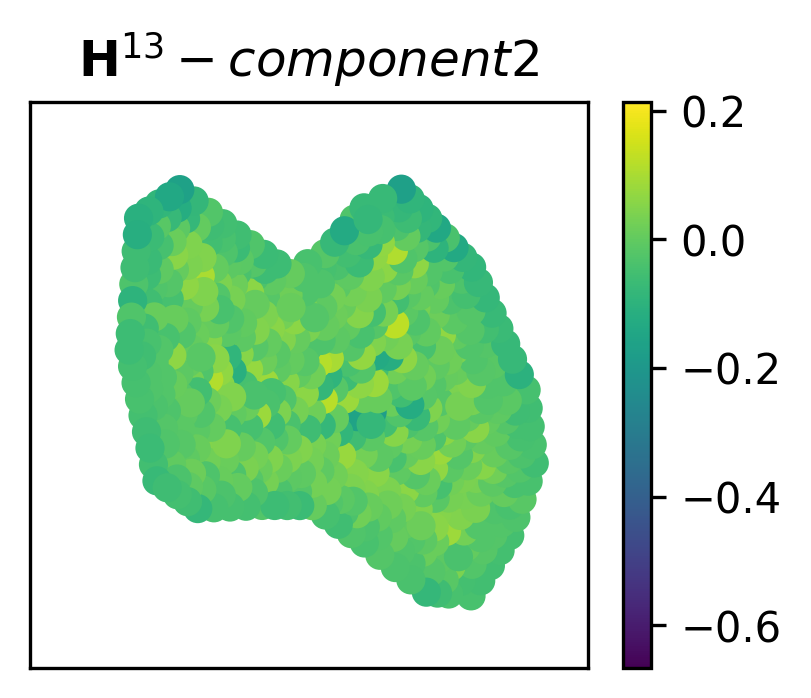

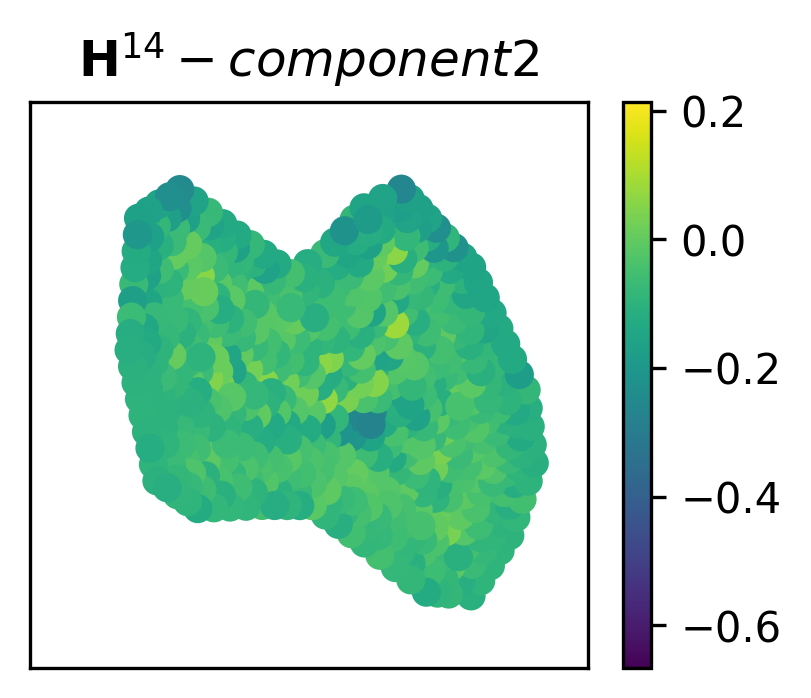

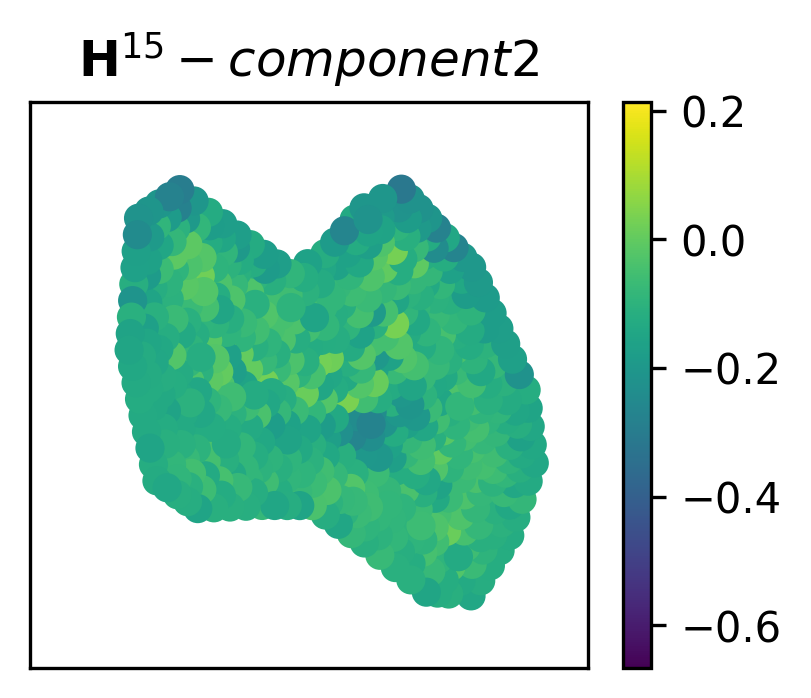

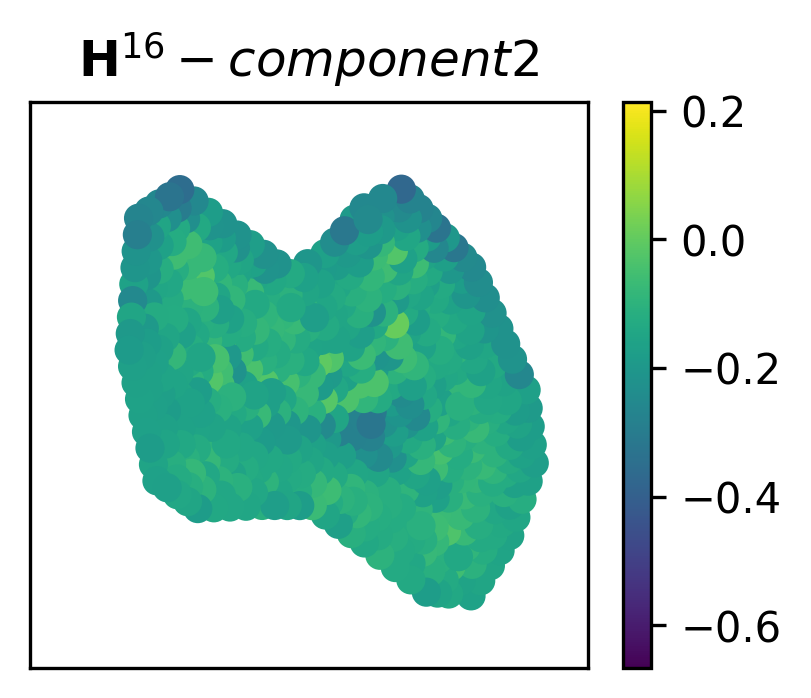

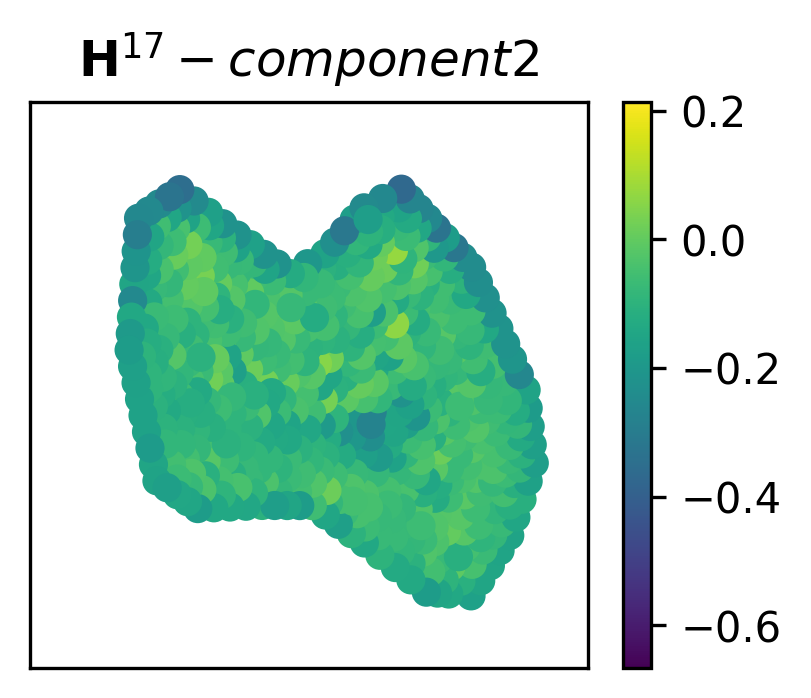

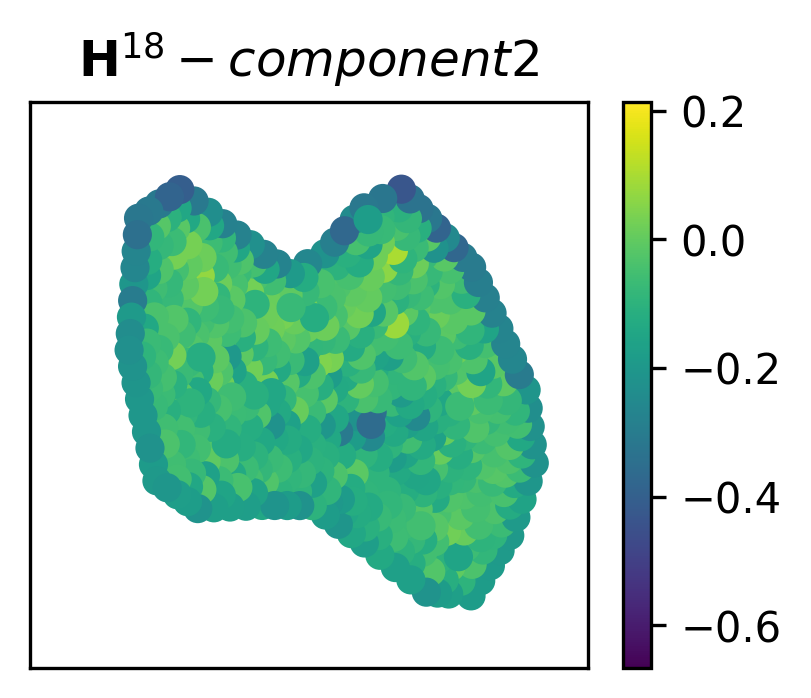

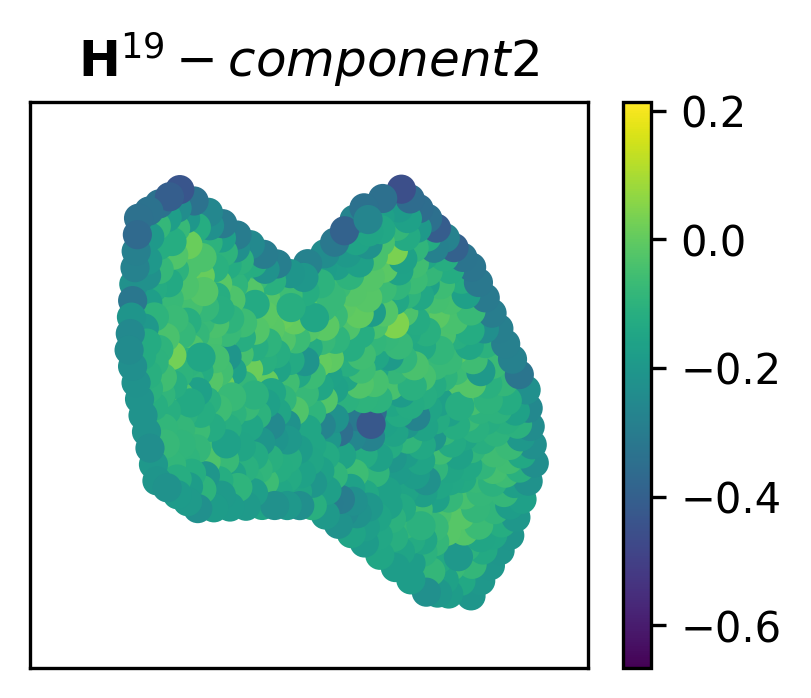

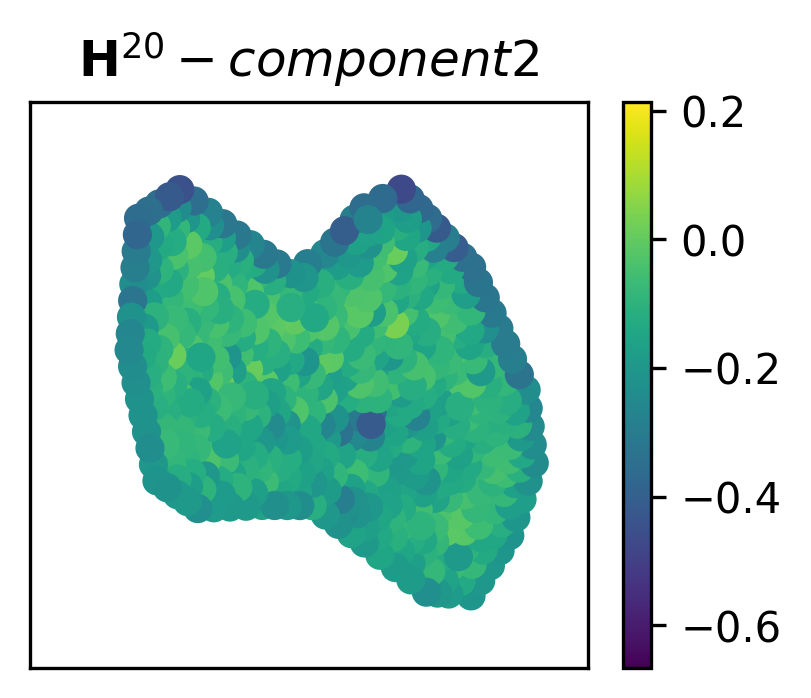

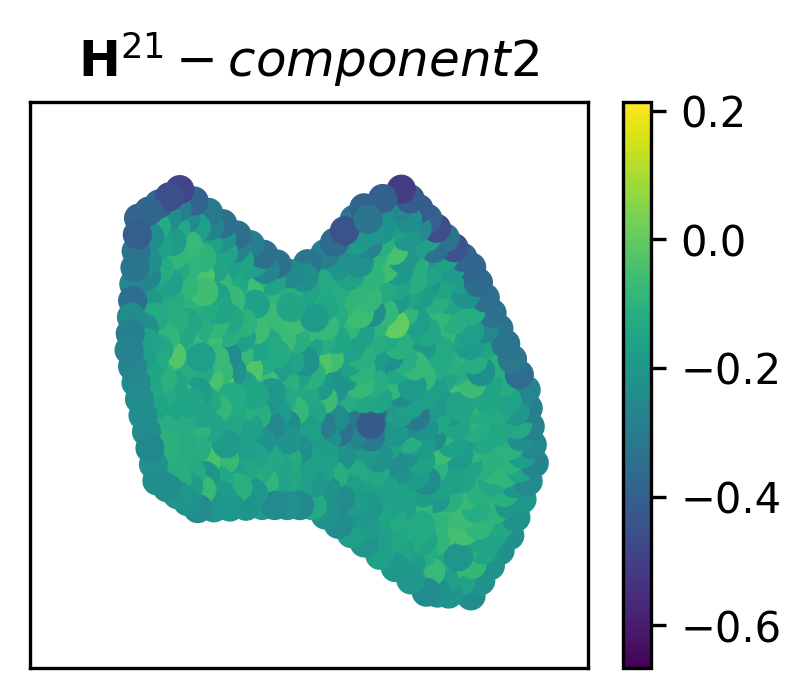

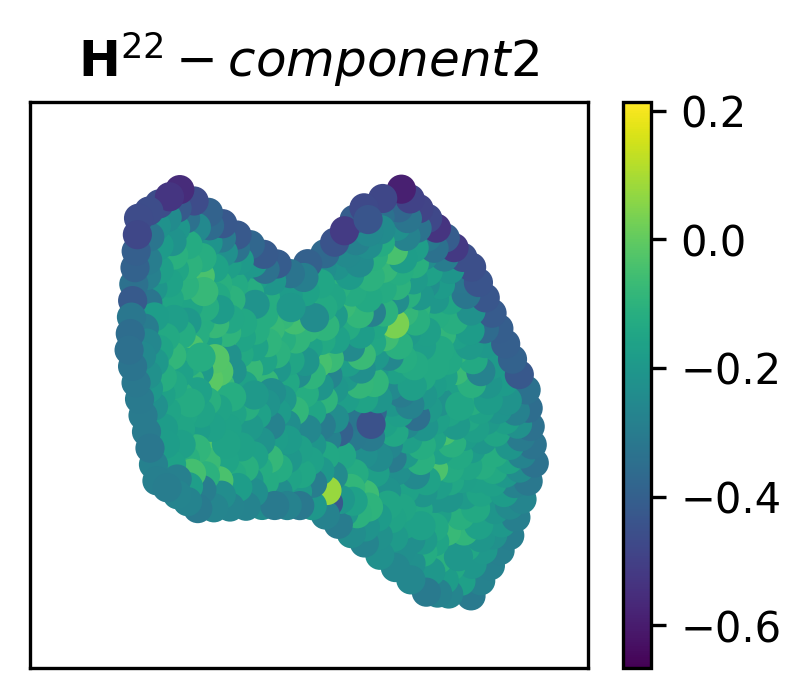

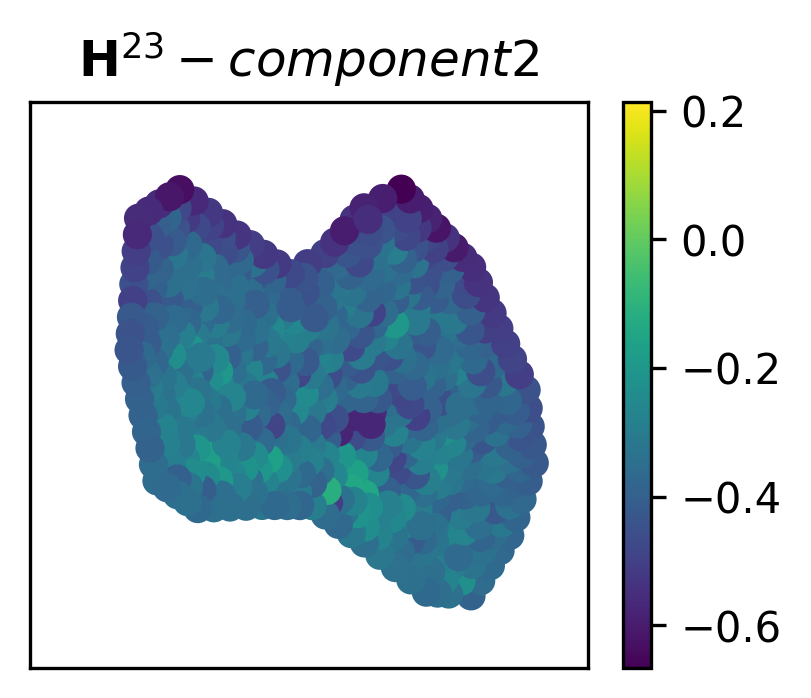

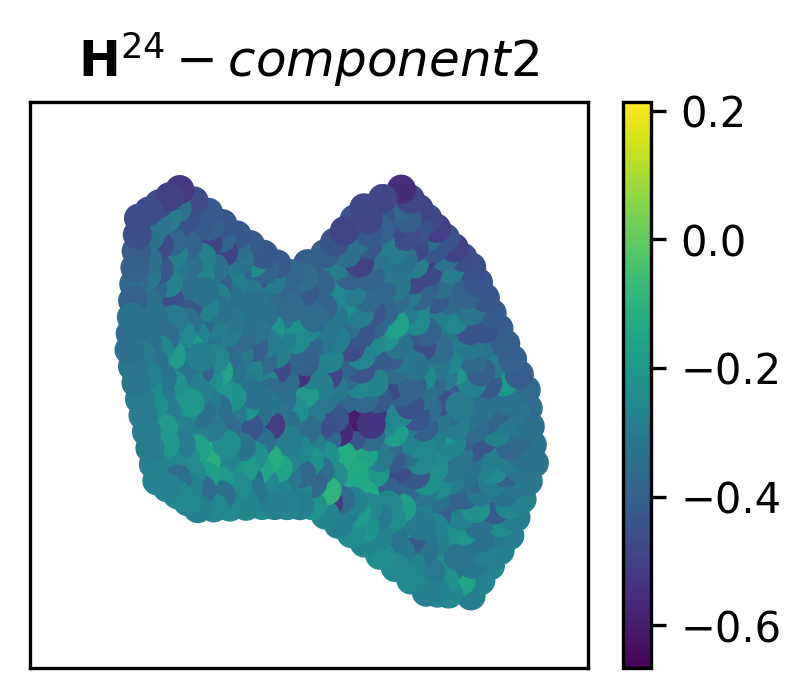

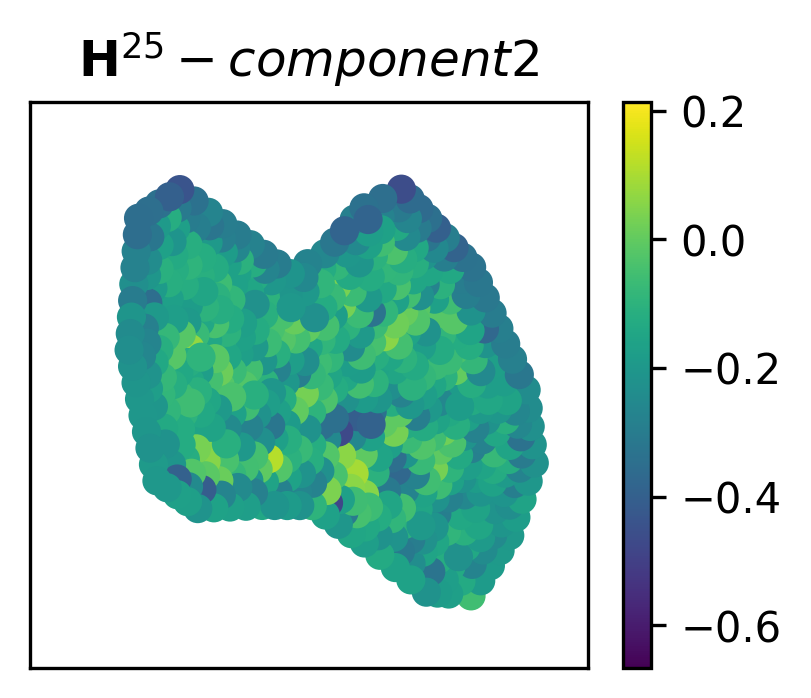

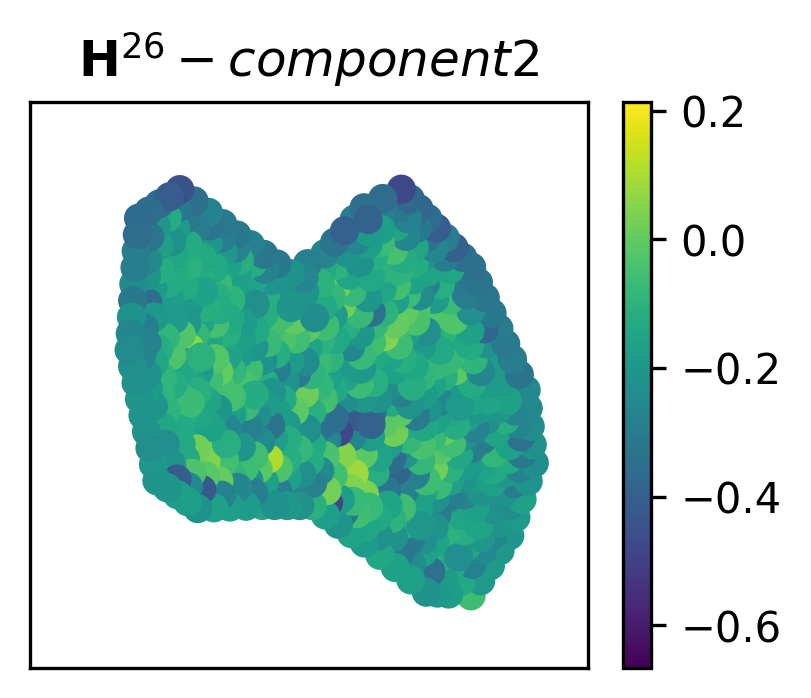

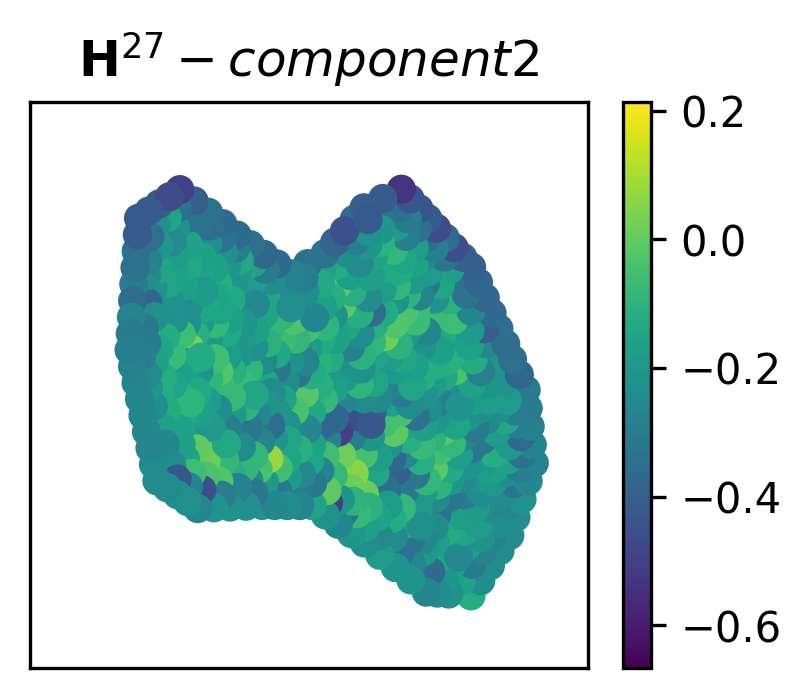

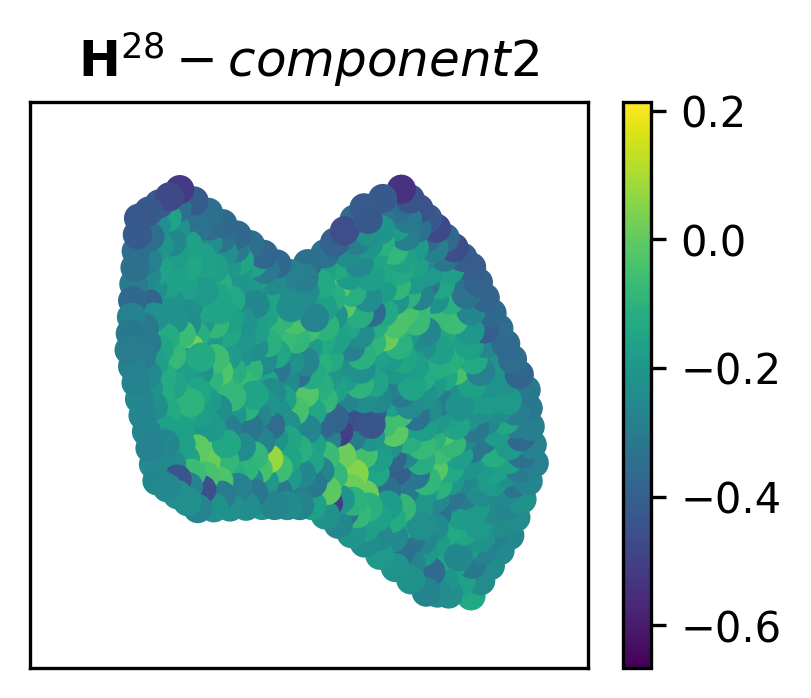

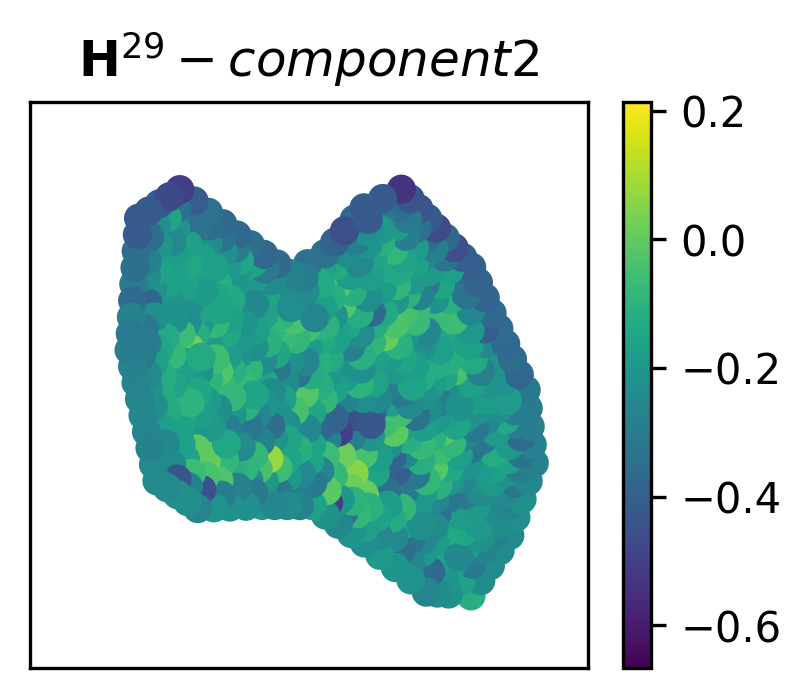

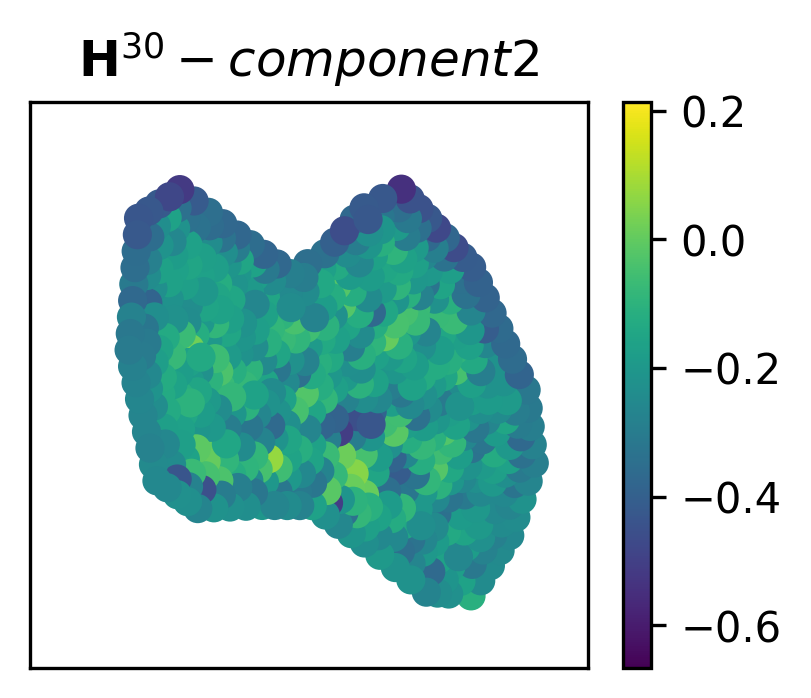

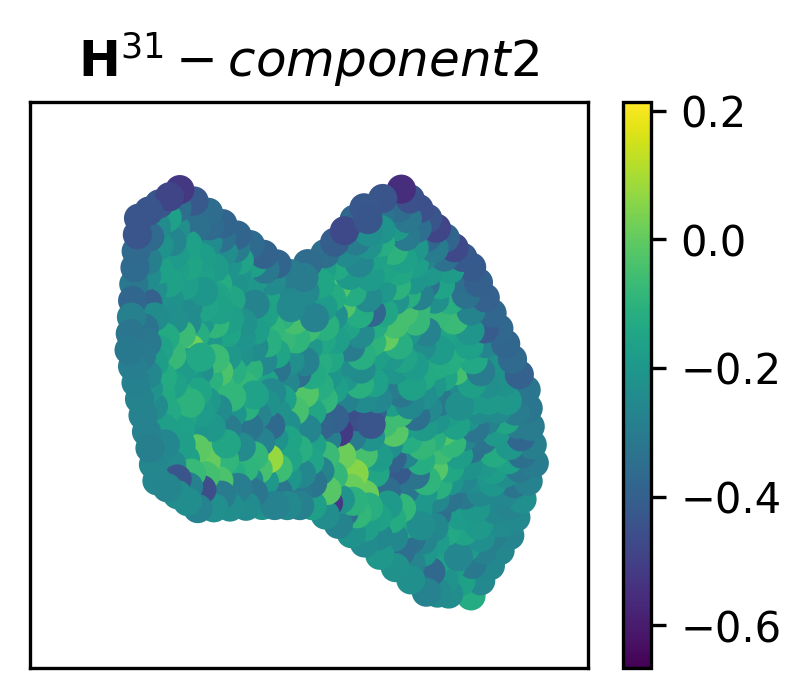

In [12]:
# Select which of the d components of H you want to visualize
component_of_H = 2

max_h = np.max(H[:,:,component_of_H])
min_h = np.min(H[:,:,component_of_H])

for frame in range(H.shape[0]):
    plt.figure(figsize=[3,2.5], dpi=300)
    
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelleft=False) # labels along the bottom edge are off
    
    plt.scatter(coordinates[:,0], coordinates[:,1], c=H[frame,:,component_of_H], zorder=2)
    plt.clim(min_h, max_h)
    plt.xlim([0.9,2.1])
    plt.ylim([0.9,2.1])
    plt.colorbar()
    plt.title(r'$\mathbf{H}^{'+str(frame+1)+'} - component {'+str(component_of_H)+'}$')
    plt.show()

# Change in distribution

As explained in the paper, we train our Deep Statistical Solver on a certain distribution of problems. This part aims at looking at what happens when the test distribution is different from the training distribution 

## Varying number of nodes

In this first experiment, we keep pretty much the same data generation process, except for the number of node output by the discretization process. We have thus generated some other datasets

In [13]:
sizes = [100, 250, 500, 750, 1000]
n_path = 'datasets/linear_systems/varying_size'

A_modified = {}
B_modified = {}
U_modified = {}
U_modified_pred = {}
corr = {}

for size in sizes:
    A_modified[size] = np.load(n_path+'/n_{}/A_test.npy'.format(size))#, allow_pickle=True)
    B_modified[size] = np.load(n_path+'/n_{}/B_test.npy'.format(size), allow_pickle=True)
    U_modified[size] = np.load(n_path+'/n_{}/U_test.npy'.format(size), allow_pickle=True)
    feed_dict={model.A:A_modified[size], model.B:B_modified[size]}
    U_modified_pred[size] = sess.run(model.U_final, feed_dict=feed_dict)
    
    U_modified_flat = np.reshape(U_modified[size], -1)
    U_modified_pred_flat = np.reshape(U_modified_pred[size], -1)
    U_modified_pred_flat = U_modified_pred_flat * (U_modified_flat != 0.)
    corr[size] = np.corrcoef(U_modified_flat, U_modified_pred_flat)[0, 1]

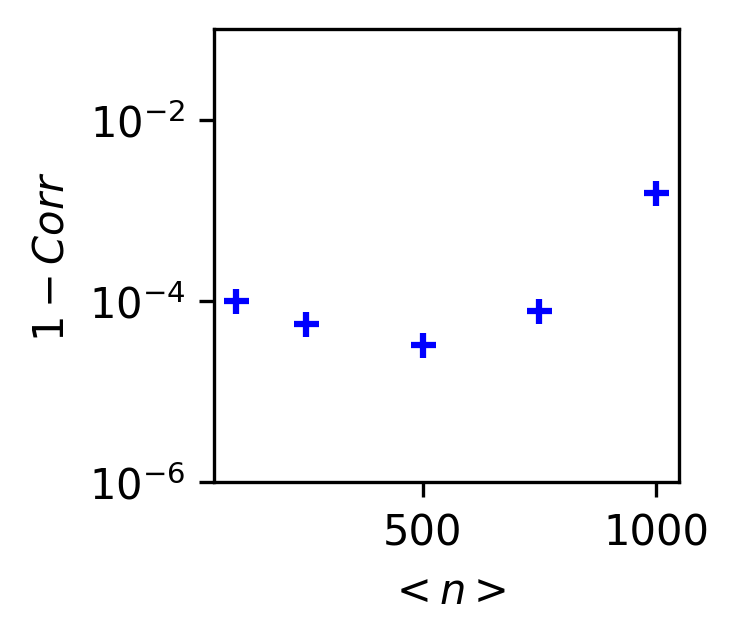

In [14]:
plt.figure(figsize=[2, 2], dpi=300)
for size in sizes:
    plt.scatter(size, 1-corr[size], color='blue', marker='+')
plt.yscale('log')
plt.xlabel(r'$<n>$')
plt.ylabel(r'$1 - Corr$')

#plt.xlim([10**(-3.5), 10**(1.5)])
plt.ylim([10**(-6), 10**(-1)])

plt.show()

In [15]:
for size in sizes:
    print(size)
    print(1-corr[size])

100
0.00010044794975183624
250
5.5010044478609466e-05
500
3.2892605861034596e-05
750
7.807625511457861e-05
1000
0.0015367728846586992


In the test set there are samples with various number of nodes. 

For samples that have fewer nodes than the amount observed in the train set, we observe an even higher correlation between our method and the LU method.

For samples that have more nodes than in the train set, the correlation is slightly worse, although it remains higher than 99%.

## Adding noise to the initial test set

Now, we conduct a more extreme experiment, where we gradually increase a noise applied to A and B

In [16]:
# Since our modelling for A and B is not so simple and straightforward, we need the following methods
# to convert A and B back to the classical representation, and to solve it

def build_A_dense(A_np, B_np):

    n_nodes = np.max(A_np[:, 0:2]).astype(np.int32)+1
    n_nodes = np.argmin((B_np[:,0]**2 + B_np[:,1]**2 + B_np[:,2]**2) != 0.)
    if n_nodes == 0:
        n_nodes = B_np[:,0].shape[0]
    
    A_dense = np.zeros([n_nodes, n_nodes])
        
    from_index = A_np[:, 0].astype(np.int32)
    to_index = A_np[:, 1].astype(np.int32)
    A_val = A_np[:, 2]
        
    A_dense[from_index, to_index] = A_val
    A_dense = A_dense - np.diag(np.sum(A_dense, axis=1))
        
    # Detect constrained nodes
    constrained_indices = (B_np[:n_nodes, 1] == 1.)
    A_dense[constrained_indices, :] = 0.
    A_dense[constrained_indices, constrained_indices] = 1.0
    
    
    B_dense = B_np[:n_nodes, 0] + B_np[:n_nodes, 2]
    
    return A_dense, B_dense

def compute_LU_solution(A_dense, B_dense):
    from scipy.linalg import lu_factor, lu_solve
    
    lu, piv = lu_factor(A_dense)
    U = lu_solve((lu, piv), B_dense)
    
    return U

In [17]:
n_samples = 100

noise_levels = 10.**np.arange(-3,2,1.)
A_np_noisy = {}
A_np_noisy_inv = {}
B_np_noisy = {}
correlations = {}

predictions = {}
solutions = {}

for noise in noise_levels:
    
    # Randomly sample from the available samples
    indices = np.random.randint(0, A_np.shape[0], n_samples)
    
    predictions[noise] = None
    solutions[noise] = None
    
    correlations[noise] = []
    
    noise_A = np.random.lognormal(0, noise, A_np.shape)
    noise_A = np.array([[[0., 0., 1.]]]) * noise_A * A_np
    cst_A = np.array([[[1., 1., 0.]]]) * A_np
    
    A_np_noisy[noise] = cst_A + noise_A
    
    
    noise_B = np.random.normal(1, noise, B_np.shape)
    noise_B = np.array([[[1.,0.,1.]]]) * noise_B * B_np
    cst_B = np.array([[[0.,1.,0.]]]) * B_np
    
    B_np_noisy[noise] = cst_B + noise_B
    
    for sample in tqdm.tqdm(indices):

        A_dense, B_dense = build_A_dense(A_np_noisy[noise][sample], B_np_noisy[noise][sample])
        # Computing solution
        try:
            U_dense = compute_LU_solution(A_dense, B_dense)
        except:
            continue
        
        U_pred = sess.run(model.U_final, feed_dict={model.A:A_np_noisy[noise][sample:sample+1],
                                                    model.B:B_np_noisy[noise][sample:sample+1]
                                                   })
        
        
        if predictions[noise] is None:
            predictions[noise] = U_pred[:,:,0]
            solutions[noise] = np.zeros(U_pred.shape[1])
            solutions[noise][:U_dense.shape[0]] = U_dense
            solutions[noise] = np.expand_dims(solutions[noise], axis=0)
            
        else :
            predictions[noise] = np.concatenate([predictions[noise], U_pred[:,:,0]], axis=0)
            solution_sample = np.zeros(U_pred.shape[1])
            solution_sample[:U_dense.shape[0]] = U_dense
            solution_sample = np.expand_dims(solution_sample, axis=0)
            solutions[noise] = np.concatenate([solutions[noise], solution_sample], axis=0)


100%|██████████| 100/100 [00:08<00:00, 12.23it/s]


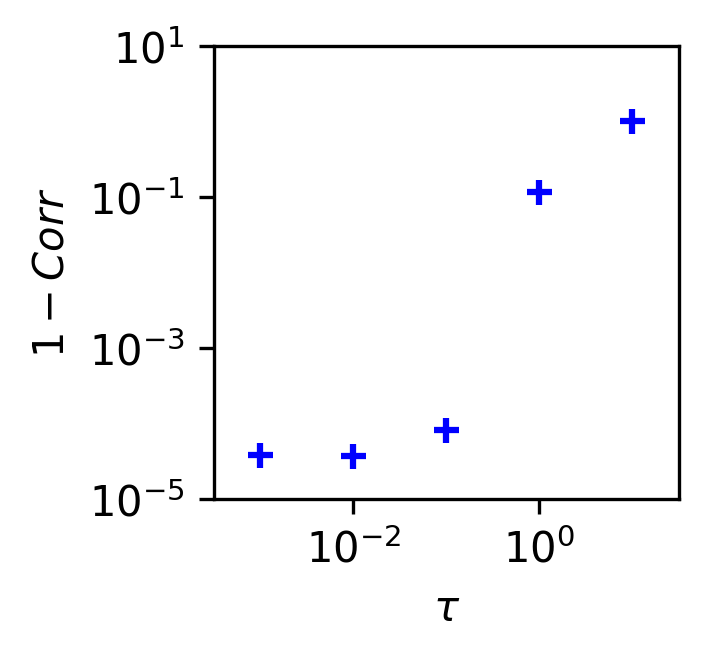

In [18]:
plt.figure(figsize=[2, 2], dpi=300)
for noise in noise_levels:
    sol = np.reshape(solutions[noise], -1)
    pred = np.reshape(predictions[noise], -1)
    corr = np.corrcoef(sol, pred)[0,1]
    plt.scatter(noise, 1-corr, color='blue', marker='+')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$1 - Corr$')

plt.xlim([10**(-3.5), 10**(1.5)])
plt.ylim([10**(-5), 10**(1)])

plt.show()

In [19]:
for noise in noise_levels:
    print(noise)
    sol = np.reshape(solutions[noise], -1)
    pred = np.reshape(predictions[noise], -1)
    corr = np.corrcoef(sol, pred)[0,1]
    print(1-corr)

0.001
3.8032296709178404e-05
0.01
3.708098364463286e-05
0.1
8.101641784885594e-05
1.0
0.11405069709547655
10.0
0.9953602722403254


For small amplitudes of noise, the correlation remains excellent (around 99.99%), but when the noise parameter tau increases, we observe that our predictions no longer match the ones of the LU method. This experiment clearly shows that we have learned to solve linear systems for a certain distribution of problems, and diverging too much from it can cause a major decrease in accuracy.